# Example - Chicago Crime

<h1>Index<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Create-a-target" data-toc-modified-id="Create-a-target-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Create a target</a></span></li><li><span><a href="#Modeling" data-toc-modified-id="Modeling-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Modeling</a></span><ul class="toc-item"><li><span><a href="#Data" data-toc-modified-id="Data-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Data</a></span></li></ul></li><li><span><a href="#Checking-the-support-in-the-different-environments" data-toc-modified-id="Checking-the-support-in-the-different-environments-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Checking the support in the different environments</a></span><ul class="toc-item"><li><span><a href="#Benchmark" data-toc-modified-id="Benchmark-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Benchmark</a></span></li></ul></li><li><span><a href="#Challenger-model" data-toc-modified-id="Challenger-model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Challenger model</a></span></li><li><span><a href="#TRF-as-feature-selection" data-toc-modified-id="TRF-as-feature-selection-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>TRF as feature selection</a></span></li><li><span><a href="#Domain-classifier" data-toc-modified-id="Domain-classifier-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Domain classifier</a></span></li></ul></div>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import shap
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from time_robust_forest.models import TimeForestClassifier
from time_robust_forest.functions import check_categoricals_match, check_numerical_match
from models.aux_functions import *

np.random.seed(42)

In [2]:
def set_style():
    plt.style.use(['seaborn-white', 'seaborn-paper'])
    plt.rcParams['figure.figsize'] = (12, 4)

In [3]:
set_style()

In [4]:
DATASETS_PATH = "~/Documents/datasets/chicago_crime/"
PREFIX = "chicago_crime"

In [5]:
data_files = ["Chicago_Crimes_2012_to_2017.csv.zip",
              "Chicago_Crimes_2008_to_2011.csv.zip",
              "Chicago_Crimes_2005_to_2007.csv.zip",
              "Chicago_Crimes_2001_to_2004.csv.zip"]

data = [pd.read_csv(DATASETS_PATH + data_file, error_bad_lines=False) for data_file in data_files]
data = pd.concat(data)

b'Skipping line 1149094: expected 23 fields, saw 41\n'
b'Skipping line 533719: expected 23 fields, saw 24\n'
b'Skipping line 1513591: expected 23 fields, saw 24\n'
Columns (17,20) have mixed types.Specify dtype option on import or set low_memory=False.


In [6]:
data.shape

(7941282, 23)

In [7]:
data.reset_index(drop=True)

,Unnamed: 0,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,3,10508693,HZ250496,05/03/2016 11:40:00 PM,013XX S SAWYER AVE,0486,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,True,...,24.0,29.0,08B,1154907.0,1.89368e+06,2016.0,05/10/2016 03:56:50 PM,41.8641,-87.706819,"(41.864073157, -87.706818608)"
1,89,10508695,HZ250409,05/03/2016 09:40:00 PM,061XX S DREXEL AVE,0486,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,...,20.0,42.0,08B,1183066.0,1.86433e+06,2016.0,05/10/2016 03:56:50 PM,41.7829,-87.604363,"(41.782921527, -87.60436317)"
2,197,10508697,HZ250503,05/03/2016 11:31:00 PM,053XX W CHICAGO AVE,0470,PUBLIC PEACE VIOLATION,RECKLESS CONDUCT,STREET,False,...,37.0,25.0,24,1140789.0,1.90482e+06,2016.0,05/10/2016 03:56:50 PM,41.8949,-87.758372,"(41.894908283, -87.758371958)"
3,673,10508698,HZ250424,05/03/2016 10:10:00 PM,049XX W FULTON ST,0460,BATTERY,SIMPLE,SIDEWALK,False,...,28.0,25.0,08B,1143223.0,1.90148e+06,2016.0,05/10/2016 03:56:50 PM,41.8857,-87.749516,"(41.885686845, -87.749515983)"
4,911,10508699,HZ250455,05/03/2016 10:00:00 PM,003XX N LOTUS AVE,0820,THEFT,$500 AND UNDER,RESIDENCE,False,...,28.0,25.0,06,1139890.0,1.90168e+06,2016.0,05/10/2016 03:56:50 PM,41.8863,-87.761751,"(41.886297242, -87.761750709)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7941277,6252586,4781176,HM386461,04/01/2001 09:00:00 AM,023XX N LATROBE AVE,0841,THEFT,FINANCIAL ID THEFT:$300 &UNDER,ALLEY,False,...,37.0,19.0,06,1140960.0,1.91506e+06,2001.0,06/14/2006 04:14:16 AM,41.923,-87.757492,"(41.922996623, -87.757491503)"
7941278,6252606,4671197,HM270817,09/01/2003 12:01:00 AM,045XX N MOBILE AVE,0840,THEFT,FINANCIAL ID THEFT: OVER $300,APARTMENT,False,...,38.0,15.0,06,1133528.0,1.92963e+06,2003.0,04/15/2016 08:55:02 AM,41.9631,-87.784457,"(41.963133955, -87.784456675)"
7941279,6252728,4671380,HM269330,08/01/2002 09:00:00 AM,020XX W 82ND PL,0840,THEFT,FINANCIAL ID THEFT: OVER $300,RESIDENCE,False,...,18.0,71.0,06,1164056.0,1.84994e+06,2002.0,04/15/2016 08:55:02 AM,41.7439,-87.674464,"(41.743865444, -87.674463733)"
7941280,6253372,4782588,HM394550,06/04/2001 12:01:00 AM,087XX S MUSKEGON AVE,0610,BURGLARY,FORCIBLE ENTRY,OTHER,False,...,10.0,46.0,05,1196570.0,1.84747e+06,2001.0,07/05/2006 04:01:36 AM,41.7363,-87.555413,"(41.736342659, -87.555413094)"


In [8]:
data = data.sample(frac=0.05)

In [9]:
data.nunique()

Unnamed: 0              392531
ID                      392531
Case Number             392528
Date                    316903
Block                    40141
IUCR                       351
Primary Type                32
Description                331
Location Description       130
Arrest                       2
Domestic                     2
Beat                       302
District                    23
Ward                        50
Community Area              78
FBI Code                    26
X Coordinate             59680
Y Coordinate             92211
Year                        17
Updated On                 926
Latitude                203973
Longitude               203423
Location                203527
dtype: int64

In [10]:
data.dtypes

Unnamed: 0                int64
ID                        int64
Case Number              object
Date                     object
Block                    object
IUCR                     object
Primary Type             object
Description              object
Location Description     object
Arrest                     bool
Domestic                   bool
Beat                      int64
District                float64
Ward                    float64
Community Area          float64
FBI Code                 object
X Coordinate            float64
Y Coordinate             object
Year                    float64
Updated On               object
Latitude                 object
Longitude               float64
Location                 object
dtype: object

In [11]:
data["Zone"] = data["Block"].apply(lambda x: x.split(" ")[1])
data["Address"] = data["Block"].apply(lambda x: " ".join(x.split(" ")[2:]))

## Modeling

### Data

In [12]:
TIME_COLUMN = "Year"
TARGET = "Arrest"

In [13]:
columns_to_label_encode = ["Primary Type", 
                           "Description",
                           "Location Description",
                           "FBI Code",
                           "Zone",
                           "Address",
                           "Domestic",
                           TARGET]

In [14]:
encoder_mappings = {}
le = LabelEncoder()
for column in columns_to_label_encode:
    print(column)
    data[column].fillna("None", inplace=True)
    data[column] = le.fit_transform(data[[column]])
    encoder_mappings[column] = {i: le.__dict__["classes_"][i] for i in range(len(le.__dict__["classes_"]))}

Primary Type


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Description
Location Description
FBI Code
Zone
Address
Domestic
Arrest


In [15]:
features = ["Primary Type", 
            "Description",
            "Location Description",
            "FBI Code",
            "Zone",
            "Address",
            "Latitude",
            "Longitude",
            "Beat",
            "District",
            "Ward",
            "Community Area",
            "Domestic"]

In [16]:
numerical_features = [f for f in features if f not in columns_to_label_encode]

In [17]:
data["Year"].value_counts()

2008.0    42828
2006.0    39622
2009.0    39206
2010.0    35026
2007.0    31000
2001.0    28345
2002.0    24663
2003.0    23843
2005.0    22711
2004.0    19386
2011.0    17583
2012.0    16793
2013.0    15446
2014.0    13753
2016.0    13185
2015.0    13083
2017.0      591
Name: Year, dtype: int64

In [18]:
data["year-month"] = pd.to_datetime(data["Date"]).apply(lambda x: str(x.year) + "-" + str(x.month).zfill(2))

In [19]:
data["Year"] = data["Year"].astype(int)

In [20]:
data["Year"].max()

2017

In [21]:
data["Latitude"] = data["Latitude"].fillna(-1).astype(float)

In [22]:
training_end_year = 2010
holdout_end_year = 2017

In [23]:
in_time = data[data["Year"] <= training_end_year]
out_of_time = data[data["Year"] > training_end_year]

In [24]:
train, test = train_test_split(in_time, 
                               test_size=0.2,
                               random_state=42)

In [25]:
train.shape

(245304, 26)

In [26]:
test.shape

(61326, 26)

In [27]:
out_of_time.shape

(90434, 26)

In [28]:
median_input = train.median()
train.fillna(median_input, inplace=True)
test.fillna(median_input, inplace=True)
out_of_time.fillna(median_input, inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## Checking the support in the different environments

In [29]:
check_categoricals_match(train, columns_to_label_encode, "Year")

Year
2001    0.896552
2002    0.896552
2003    0.896552
2004    0.931034
2005    0.931034
2006    0.931034
2007    0.931034
2008    0.896552
2009    0.931034
2010    0.965517
Name: Primary Type, dtype: float64
Year
2001    0.607843
2002    0.663399
2003    0.718954
2004    0.696078
2005    0.745098
2006    0.771242
2007    0.741830
2008    0.797386
2009    0.797386
2010    0.777778
Name: Description, dtype: float64
Year
2001    0.688525
2002    0.647541
2003    0.713115
2004    0.721311
2005    0.688525
2006    0.704918
2007    0.696721
2008    0.704918
2009    0.737705
2010    0.803279
Name: Location Description, dtype: float64
Year
2001    0.961538
2002    0.961538
2003    0.961538
2004    0.961538
2005    0.961538
2006    1.000000
2007    0.961538
2008    0.961538
2009    0.961538
2010    0.961538
Name: FBI Code, dtype: float64
Year
2001    1.0
2002    1.0
2003    1.0
2004    1.0
2005    1.0
2006    1.0
2007    1.0
2008    1.0
2009    1.0
2010    1.0
Name: Zone, dtype: float64
Year


0.8533295766355395

In [30]:
check_numerical_match(train, numerical_features, TIME_COLUMN, verbose=True, n_q=10)

Year
2001    0.666667
2002    0.666667
2003    0.666667
2004    0.666667
2005    0.666667
2006    0.666667
2007    0.666667
2008    1.000000
2009    0.666667
2010    1.000000
Name: Latitude_quant, dtype: float64
Year
2001    0.5
2002    0.5
2003    0.5
2004    0.5
2005    0.5
2006    0.5
2007    0.5
2008    1.0
2009    0.5
2010    1.0
Name: Longitude_quant, dtype: float64
Year
2001    1.0
2002    1.0
2003    1.0
2004    1.0
2005    1.0
2006    1.0
2007    1.0
2008    1.0
2009    1.0
2010    1.0
Name: Beat_quant, dtype: float64
Year
2001    0.888889
2002    0.888889
2003    0.888889
2004    0.888889
2005    0.888889
2006    0.888889
2007    0.888889
2008    1.000000
2009    1.000000
2010    0.888889
Name: District_quant, dtype: float64
Year
2001    1.0
2002    1.0
2003    1.0
2004    1.0
2005    1.0
2006    1.0
2007    1.0
2008    1.0
2009    1.0
2010    1.0
Name: Ward_quant, dtype: float64
Year
2001    1.0
2002    1.0
2003    1.0
2004    1.0
2005    1.0
2006    1.0
2007    1.0
2008    


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0.8740740740740741

### Benchmark

In [31]:
from pycaret.classification import *

In [32]:
TARGET

'Arrest'

In [33]:
clf1 = setup(train[features + [TARGET]], 
             target=TARGET,
             session_id=2, 
             log_experiment=False, 
             experiment_name="{}".format(PREFIX),
             silent=True)

rf = create_model('rf')
tuned_rf = tune_model(rf,
                     optimize="AUC",
                     fold=5,
                     n_iter=50)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8735,0.9025,0.7032,0.8368,0.7642,0.6787,0.6834
1,0.8709,0.8998,0.7009,0.8297,0.7599,0.6724,0.6769
2,0.8701,0.9025,0.7020,0.8263,0.7591,0.6710,0.6752
3,0.8738,0.9074,0.6979,0.8421,0.7632,0.6782,0.6838
4,0.8743,0.9053,0.7019,0.8404,0.7649,0.6801,0.6852
Mean,0.8725,0.9035,0.7012,0.8351,0.7623,0.6761,0.6809
SD,0.0017,0.0026,0.0018,0.0061,0.0024,0.0036,0.0041


In [34]:
tuned_rf

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='entropy',
                       max_depth=9, max_features='log2', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0,
                       min_impurity_split=None, min_samples_leaf=3,
                       min_samples_split=10, min_weight_fraction_leaf=0.0,
                       n_estimators=80, n_jobs=-1, oob_score=False,
                       random_state=2, verbose=0, warm_start=False)

In [35]:
benchmark_model = tuned_rf
benchmark_model.fit(train[features], train[TARGET])

train["benchmark_prediction_opt"] = benchmark_model.predict_proba(train[features])[:, 1]
test["benchmark_prediction_opt"] = benchmark_model.predict_proba(test[features])[:, 1]
out_of_time["benchmark_prediction_opt"] = benchmark_model.predict_proba(out_of_time[features])[:, 1]

In [36]:
print(roc_auc_score(train[TARGET], train["benchmark_prediction_opt"]))
print(roc_auc_score(test[TARGET], test["benchmark_prediction_opt"]))
print(roc_auc_score(out_of_time[TARGET], out_of_time["benchmark_prediction_opt"]))

0.9078089195113677
0.902446815167179
0.9027129283662529


In [37]:
benchmark_model = RandomForestClassifier(n_estimators=250, max_depth=8)
benchmark_model.fit(train[features], train[TARGET])

train["benchmark_prediction"] = benchmark_model.predict_proba(train[features])[:, 1]
test["benchmark_prediction"] = benchmark_model.predict_proba(test[features])[:, 1]
out_of_time["benchmark_prediction"] = benchmark_model.predict_proba(out_of_time[features])[:, 1]

In [38]:
print(roc_auc_score(train[TARGET], train["benchmark_prediction"]))
print(roc_auc_score(test[TARGET], test["benchmark_prediction"]))
print(roc_auc_score(out_of_time[TARGET], out_of_time["benchmark_prediction"]))

0.9032900305730233
0.899364730180722
0.9002264784664266


In [39]:
# benchmark_importances = benchmark_model.feature_importances_
# benchmark_importances = pd.Series(benchmark_importances, index=features)
# benchmark_importances.rename("RF", inplace=True)

In [40]:
results = reverse_learning_curve(train, out_of_time, tuned_rf, features, TARGET, TIME_COLUMN, roc_auc_score, n_rounds=5)

In [41]:
benchmark_importances = results["feature_importance"][-1].copy(deep=True)
benchmark_importances.rename("RF", inplace=True)

Primary Type            0.049913
Description             0.051956
Location Description    0.016198
FBI Code                0.234011
Zone                    0.000168
Address                 0.000966
Latitude                0.001733
Longitude               0.001474
Beat                    0.001326
District                0.000551
Ward                    0.000362
Community Area          0.000149
Domestic                0.002452
Name: RF, dtype: float64

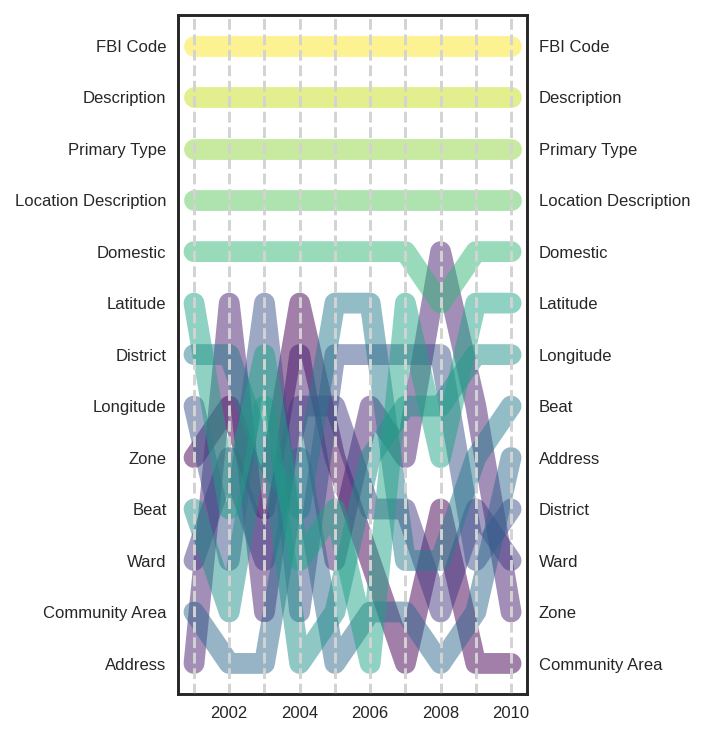

In [42]:
importance_by_reverse_segment_benchmark = plot_feature_migration_from_learning_curve_results(results, features, 
                                                                                             save_as="../images/{}_benchmark_importance_migration_learning_curve.eps".format(PREFIX))

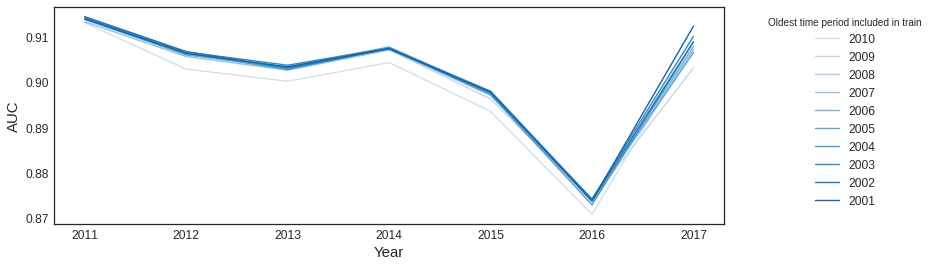

In [43]:
fig, ax = plt.subplots()

blues = plt.get_cmap("Blues")
gradient = np.linspace(.2, 0.8, len(results["holdout_performance"]))

for i, r in enumerate(results["holdout_performance_by_period"]):
    r.plot(label=results["last_period_included"][i], color=blues(gradient[i]))

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(bbox_to_anchor=(1.05, 1.0), fontsize=12, title="Oldest time period included in train")
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Year", fontsize=15)

plt.savefig("../images/{}_perf_by_period_reverse_learning_curve_benchmark.eps".format(PREFIX), format="eps", bbox_inches = "tight")
plt.show()

In [44]:
results

{'round': [],
 'holdout_performance': [0.8998842919061307,
  0.9024842675627911,
  0.902451081048006,
  0.902229670093485,
  0.9026887003680262,
  0.9027105729540601,
  0.9024657586795166,
  0.903014736927577,
  0.9028557557536315,
  0.9027129283662529],
 'feature_importance': [Primary Type            0.041149
  Description             0.056663
  Location Description    0.015234
  FBI Code                0.237769
  Zone                    0.000139
  Address                 0.000046
  Latitude                0.000607
  Longitude              -0.000180
  Beat                   -0.000137
  District               -0.000201
  Ward                    0.000103
  Community Area          0.000053
  Domestic                0.004921
  Name: 2010, dtype: float64,
  Primary Type            0.043365
  Description             0.059825
  Location Description    0.012704
  FBI Code                0.239425
  Zone                    0.000277
  Address                -0.000258
  Latitude                0.

## Challenger model

In [38]:
train.reset_index(drop=True, inplace=True)

In [39]:
train[features + [TIME_COLUMN]]

,Primary Type,Description,Location Description,FBI Code,Zone,Address,Latitude,Longitude,Beat,District,Ward,Community Area,Domestic,Year
0,6,296,23,16,4,48,41.691525,-87.703619,2211,22.0,19.0,74.0,0,2009
1,8,142,22,13,3,1201,41.750185,-87.644030,621,6.0,17.0,71.0,0,2003
2,16,71,95,8,4,602,41.939387,-87.699018,1411,14.0,33.0,21.0,0,2010
3,30,143,73,7,4,923,41.997641,-87.695070,2412,24.0,50.0,2.0,0,2002
4,6,296,17,16,4,2399,41.965320,-87.663314,2311,19.0,46.0,3.0,0,2008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245299,16,289,61,8,2,1494,41.987575,-87.755696,1621,16.0,45.0,12.0,0,2004
245300,1,275,101,9,3,1371,41.680650,-87.660265,524,5.0,34.0,53.0,0,2008
245301,6,296,101,16,3,800,41.760222,-87.681799,835,8.0,18.0,66.0,0,2009
245302,16,71,117,8,3,2353,41.764103,-87.690572,831,8.0,18.0,66.0,0,2008


In [40]:
train["Year"].value_counts()

2008    34293
2006    31632
2009    31340
2010    28021
2007    24887
2001    22761
2002    19643
2003    19055
2005    18238
2004    15434
Name: Year, dtype: int64

In [41]:
CHALLENGER_MAX_DEPTH = 9
CHALLENGER_N_ESTIMATORS = 80
CHALLENGER_MIN_SAMPLES_BY_PERIODS = 2

In [49]:
challenger_model_max = TimeForestClassifier(time_column=TIME_COLUMN,
                                        n_estimators=CHALLENGER_N_ESTIMATORS,
                                        min_sample_periods=CHALLENGER_MIN_SAMPLES_BY_PERIODS,
                                        max_depth=CHALLENGER_MAX_DEPTH,
                                        period_criterion='max',
                                        multi=True)

challenger_model_max.fit(train[features + [TIME_COLUMN]], train[TARGET].values)

In [50]:
train["challenger_prediction_max"] = challenger_model_max.predict_proba(train[features])[:, 1]
test["challenger_prediction_max"] = challenger_model_max.predict_proba(test[features])[:, 1]
out_of_time["challenger_prediction_max"] = challenger_model_max.predict_proba(out_of_time[features])[:, 1]

In [51]:
print(roc_auc_score(train[TARGET], train["challenger_prediction_max"]))
print(roc_auc_score(test[TARGET], test["challenger_prediction_max"]))
print(roc_auc_score(out_of_time[TARGET], out_of_time["challenger_prediction_max"]))

0.9006901167752384
0.8985222265739621
0.8990783585681751


In [52]:
challenger_model_max.feature_importance()

challenger_model_max_importances = challenger_model_max.feature_importance()
challenger_model_max_importances.rename("TRF Max", inplace=True)

Description             2449
Latitude                2250
Longitude               2111
Location Description    2089
Beat                    2022
Address                 1836
Primary Type            1640
FBI Code                1512
District                1213
Zone                     682
Domestic                 401
Community Area           252
Ward                     232
Name: TRF Max, dtype: int64

In [42]:
challenger_model = TimeForestClassifier(time_column=TIME_COLUMN,
                                        n_estimators=CHALLENGER_N_ESTIMATORS,
                                        min_sample_periods=CHALLENGER_MIN_SAMPLES_BY_PERIODS,
                                        max_depth=CHALLENGER_MAX_DEPTH,
                                        multi=True)
challenger_model.fit(train[features + [TIME_COLUMN]], train[TARGET].values)

train["challenger_prediction"] = challenger_model.predict_proba(train[features])[:, 1]
test["challenger_prediction"] = challenger_model.predict_proba(test[features])[:, 1]
out_of_time["challenger_prediction"] = challenger_model.predict_proba(out_of_time[features])[:, 1]

In [43]:
print(roc_auc_score(train[TARGET], train["challenger_prediction"]))
print(roc_auc_score(test[TARGET], test["challenger_prediction"]))
print(roc_auc_score(out_of_time[TARGET], out_of_time["challenger_prediction"]))

0.900643608997737
0.8985398318672595
0.8990156858640277


## Feature Importance migration

In [55]:
challenger_model = TimeForestClassifier(time_column=TIME_COLUMN,
                                        n_estimators=CHALLENGER_N_ESTIMATORS,
                                        min_sample_periods=CHALLENGER_MIN_SAMPLES_BY_PERIODS,
                                        max_depth=CHALLENGER_MAX_DEPTH,
                                        multi=True)

results_trt = reverse_learning_curve(train, out_of_time, challenger_model, features, TARGET, TIME_COLUMN, roc_auc_score, n_rounds=5, trt_model=True)

In [56]:
challenger_model_importances = results_trt["feature_importance"][-1].copy(deep=True)
challenger_model_importances.rename("TRF", inplace=True)

Primary Type            0.083420
Description             0.078624
Location Description    0.012879
FBI Code                0.095230
Zone                    0.000129
Address                -0.000252
Latitude               -0.002026
Longitude               0.000161
Beat                    0.000305
District               -0.000036
Ward                   -0.000366
Community Area          0.000011
Domestic                0.001562
Name: TRF, dtype: float64

In [57]:
all_models_importance = pd.DataFrame(index=features)
all_models_importance = all_models_importance.merge(benchmark_importances, how="left", left_index=True, 
                            right_index=True)
all_models_importance = all_models_importance.merge(challenger_model_importances, how="left", left_index=True, 
                            right_index=True)
all_models_importance = all_models_importance.merge(challenger_model_max_importances, how="left", left_index=True, 
                            right_index=True)

all_models_importance.fillna(0, inplace=True)
all_models_importance

,RF,TRF,TRF Max
Primary Type,0.049913,0.083420,1640
Description,0.051956,0.078624,2449
Location Description,0.016198,0.012879,2089
FBI Code,0.234011,0.095230,1512
Zone,0.000168,0.000129,682
Address,0.000966,-0.000252,1836
Latitude,0.001733,-0.002026,2250
Longitude,0.001474,0.000161,2111
Beat,0.001326,0.000305,2022
District,0.000551,-0.000036,1213


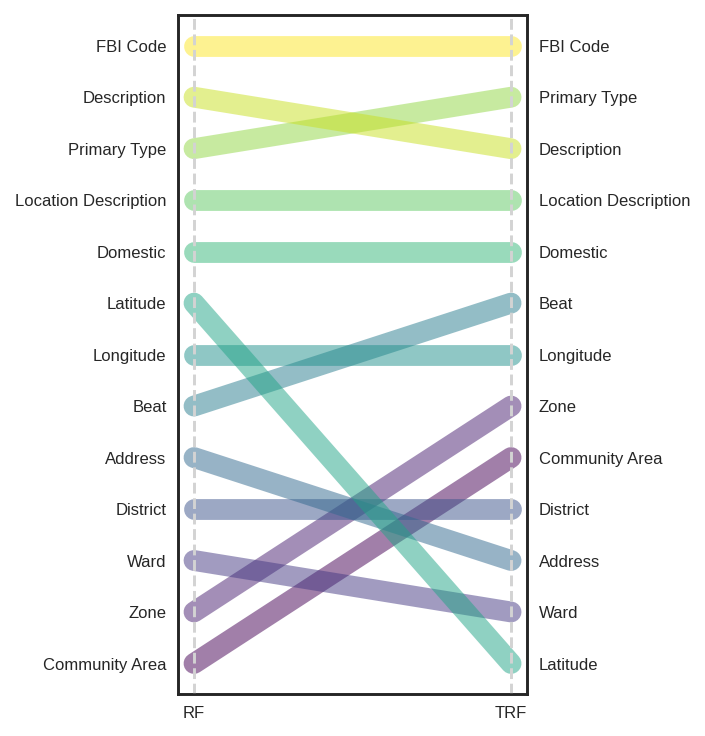

In [58]:
plot_shap_difference(all_models_importance[["RF", "TRF"]], title="", save_as="../images/{}_importance_migration.eps".format(PREFIX))

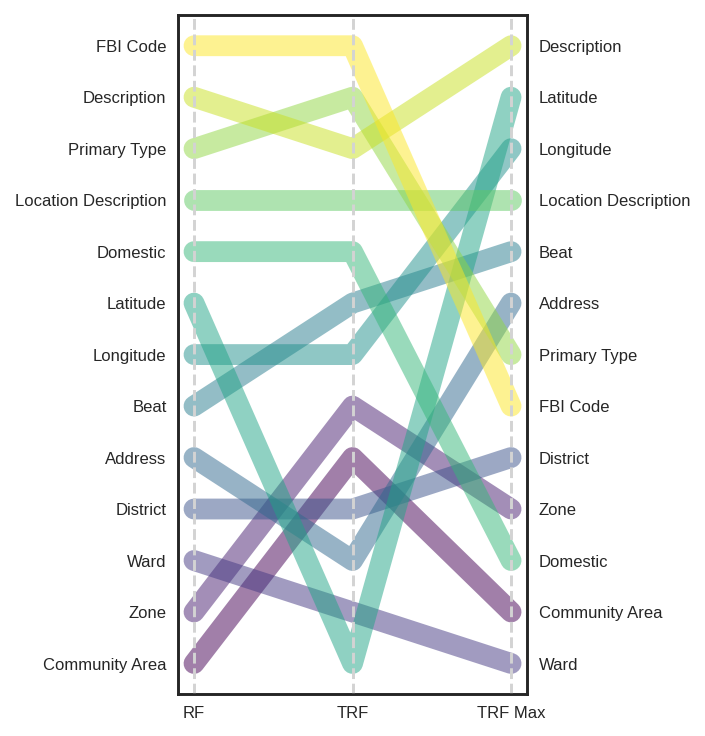

In [59]:
plot_shap_difference(all_models_importance, title="", save_as="../images/{}_importance_migration_trf_max.eps".format(PREFIX))

## Reverse Learning Curve

,2010,2009,2008,2007,2006,2005,2004,2003,2002,2001
Primary Type,0.078393,0.068200,0.084235,0.083387,0.074854,0.081255,0.076710,0.079588,0.080035,0.083420
Description,0.078524,0.077265,0.090957,0.094634,0.066757,0.076615,0.077996,0.076699,0.074613,0.078624
Location Description,0.015292,0.012267,0.013073,0.012722,0.010979,0.012424,0.013928,0.010224,0.014439,0.012879
FBI Code,0.100191,0.147610,0.127921,0.110745,0.149096,0.143511,0.122831,0.117514,0.118143,0.095230
Zone,0.000453,0.000121,0.000046,0.000375,0.000015,0.000138,0.000210,0.000114,0.000096,0.000129
Address,0.001620,0.000890,0.000584,0.000403,0.000060,0.000348,0.000414,0.000095,0.000878,0.000252
Latitude,0.001392,0.001957,0.001096,0.000882,0.002522,0.000049,0.000188,0.000972,0.000834,0.002026
Longitude,0.001086,0.001126,0.000458,0.000302,0.000554,0.000835,0.000064,0.000160,0.000621,0.000161
Beat,0.000299,0.001791,0.000318,0.000932,0.000238,0.002063,0.000277,0.000788,0.000340,0.000305
District,0.001503,0.000926,0.000390,0.000800,0.000588,0.001318,0.000270,0.000370,0.000487,0.000036


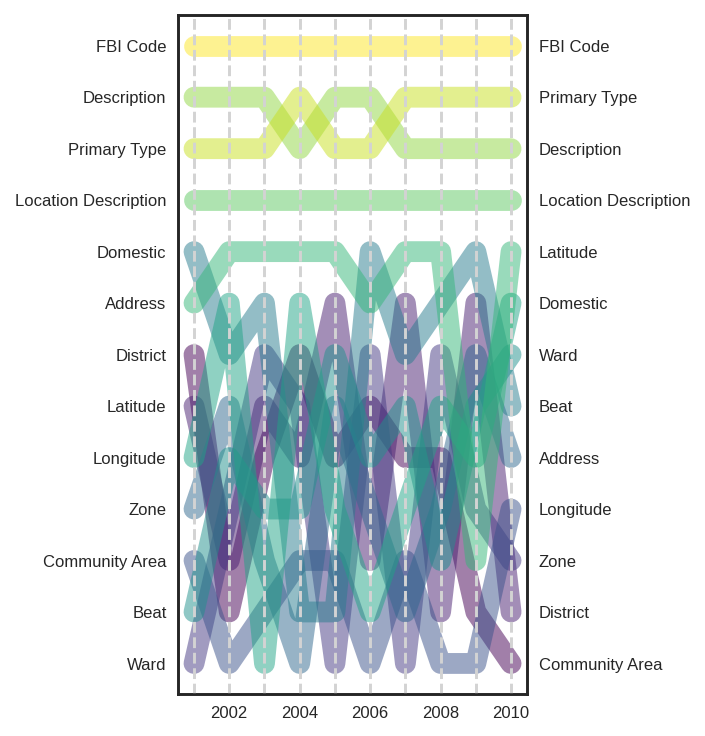

In [60]:
importance_by_reverse_segment_challenger = plot_feature_migration_from_learning_curve_results(results_trt, features, 
                                                                                             save_as="../images/{}_challenger_importance_migration_learning_curve.eps".format(PREFIX))
importance_by_reverse_segment_challenger

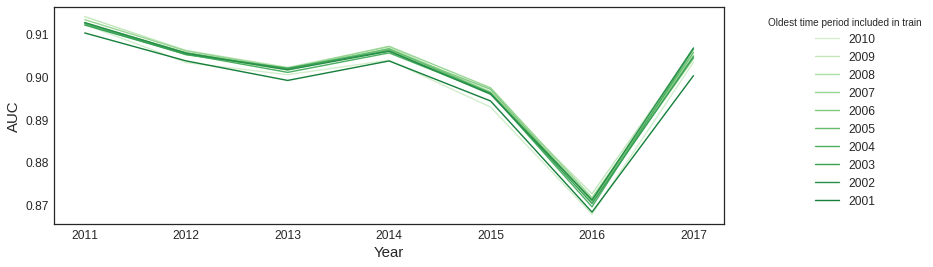

In [61]:
fig, ax = plt.subplots()

greens = plt.get_cmap("Greens")
gradient = np.linspace(.2, 0.8, len(results_trt["holdout_performance"]))

for i, r in enumerate(results_trt["holdout_performance_by_period"]):
    r.plot(label=results_trt["last_period_included"][i], color=greens(gradient[i]))

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(bbox_to_anchor=(1.05, 1.0), fontsize=12, title="Oldest time period included in train")
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Year", fontsize=15)

plt.savefig("../images/{}_perf_by_period_reverse_learning_curve_challenger.eps".format(PREFIX), format="eps", bbox_inches = "tight")
plt.show()

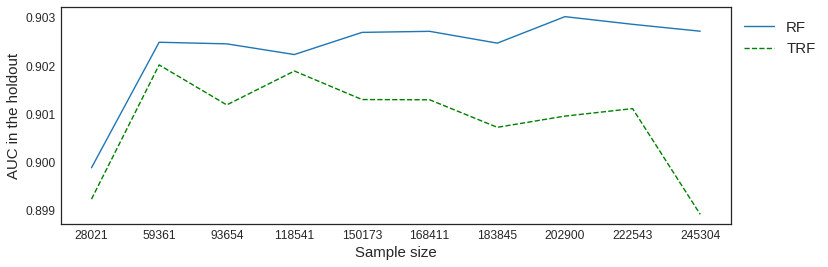

In [62]:
fig, ax = plt.subplots()
plt.plot([str(i) for i in results["sample_size"]], results["holdout_performance"], label="RF")
plt.plot(results_trt["holdout_performance"], label="TRF", linestyle="dashed", color="green")
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(fontsize=15, bbox_to_anchor=(1.0, 1.0))
plt.ylabel("AUC in the holdout", fontsize=15)
plt.xlabel("Sample size", fontsize=15)
plt.savefig("../images/{}_reverse_learning_curve_sample.eps".format(PREFIX), format="eps")
plt.show()

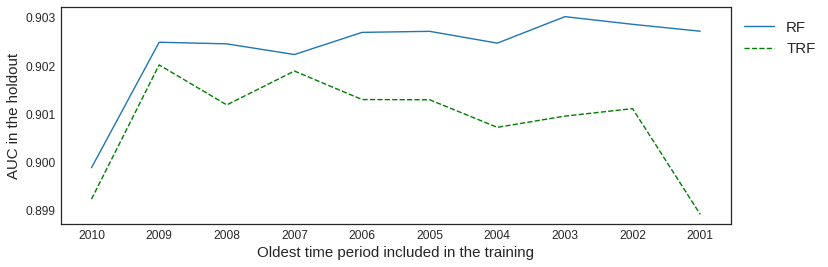

In [63]:
fig, ax = plt.subplots()
plt.plot([str(i) for i in results["last_period_included"]], results["holdout_performance"], label="RF")
plt.plot(results_trt["holdout_performance"], label="TRF", linestyle="dashed", color="green")
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(fontsize=15, bbox_to_anchor=(1.0, 1.0))
plt.ylabel("AUC in the holdout", fontsize=15)
plt.xlabel("Oldest time period included in the training", fontsize=15)
plt.savefig("../images/{}_reverse_learning_curve_segments.eps".format(PREFIX), format="eps")
plt.show()

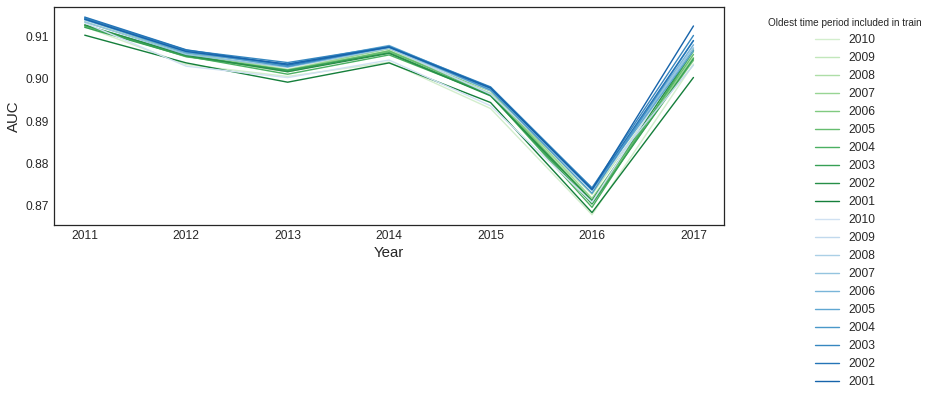

In [64]:
fig, ax = plt.subplots()

greens = plt.get_cmap("Greens")
gradient = np.linspace(.2, 0.8, len(results_trt["holdout_performance"]))

for i, r in enumerate(results_trt["holdout_performance_by_period"]):
    r.plot(label=results_trt["last_period_included"][i], color=greens(gradient[i]))
    
for i, r in enumerate(results["holdout_performance_by_period"]):
    r.plot(label=results["last_period_included"][i], color=blues(gradient[i]))

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(bbox_to_anchor=(1.05, 1.0), fontsize=12, title="Oldest time period included in train")
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Year", fontsize=15)

plt.savefig("../images/{}_perf_by_period_reverse_learning_curve_both.eps".format(PREFIX), format="eps", bbox_inches = "tight")
plt.show()

## Performance comparison

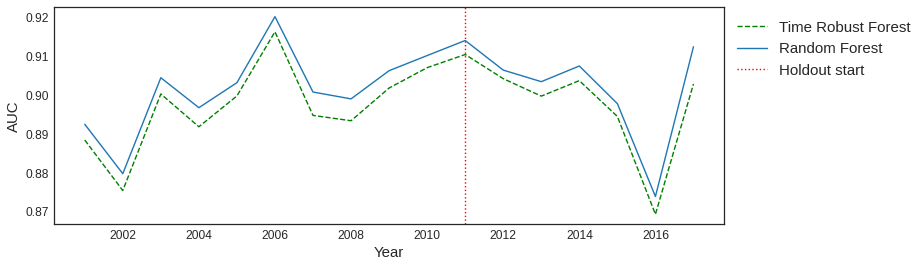

In [65]:
fig, ax = plt.subplots()
pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["challenger_prediction"])).plot(label="Time Robust Forest", 
                                                                                                      linestyle="dashed",
                                                                                                      color="green", ax=ax)
pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["benchmark_prediction_opt"])).plot(label="Random Forest", ax=ax)

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)

xmin, xmax, ymin, ymax = plt.axis()
plt.vlines(training_end_year + 1, ymin, ymax, linestyle="dotted", color="red", label="Holdout start")
plt.ylim([ymin, ymax])
plt.legend(fontsize=15, bbox_to_anchor=(1.0, 1.0))
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Year", fontsize=15)
plt.savefig("../images/{}_test_holdout_auc_years.eps".format(PREFIX), format="eps")
plt.show()

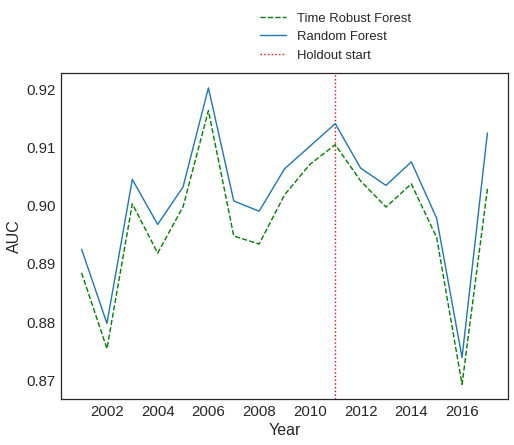

In [66]:
plt.rcParams['figure.figsize'] = (8, 6)
fig, ax = plt.subplots()
pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["challenger_prediction"])).plot(label="Time Robust Forest", 
                                                                                                      linestyle="dashed",
                                                                                                      color="green", ax=ax)
pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["benchmark_prediction_opt"])).plot(label="Random Forest", ax=ax)


ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)

xmin, xmax, ymin, ymax = plt.axis()
plt.vlines(training_end_year + 1, ymin, ymax, linestyle="dotted", color="red", label="Holdout start")
plt.ylim([ymin, ymax])
plt.legend(fontsize=13, bbox_to_anchor=(0.42, 1.0))

plt.ylabel("AUC", fontsize=16)
plt.xlabel("Year", fontsize=16)
plt.savefig("../images/{}_test_holdout_auc_years_square.eps".format(PREFIX), format="eps")
plt.show()

## TRF as feature selection

In [67]:
challenger_model.feature_importance()

Description             2437
Latitude                2283
Longitude               2107
Location Description    2103
Beat                    2002
Address                 1796
Primary Type            1669
FBI Code                1470
District                1124
Zone                     676
Domestic                 396
Community Area           290
Ward                     224
Name: Feature Importance, dtype: int64

In [68]:
selected_features = [feature for feature in features if feature in challenger_model.feature_importance().index]
selected_features

['Primary Type',
 'Description',
 'Location Description',
 'FBI Code',
 'Zone',
 'Address',
 'Latitude',
 'Longitude',
 'Beat',
 'District',
 'Ward',
 'Community Area',
 'Domestic']

In [69]:
if len(selected_features) == len(features):
    selected_features = list(challenger_model.feature_importance().sort_values(ascending=False).index[:int(len(features)/2)+2].values)
    
selected_features    

['Description',
 'Latitude',
 'Longitude',
 'Location Description',
 'Beat',
 'Address',
 'Primary Type',
 'FBI Code']

In [70]:
selected_features

['Description',
 'Latitude',
 'Longitude',
 'Location Description',
 'Beat',
 'Address',
 'Primary Type',
 'FBI Code']

In [71]:
clf1 = setup(train[selected_features + [TARGET]], 
             target=TARGET,
             session_id=3, 
             log_experiment=False, 
             experiment_name="{}_fs".format(PREFIX),
             silent=True)

rf = create_model('rf')
tuned_rf = tune_model(rf,
                     optimize="AUC",
                     fold=5,
                     n_iter=50)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8675,0.9033,0.7125,0.8094,0.7578,0.6672,0.6697
1,0.8691,0.9019,0.7150,0.8125,0.7606,0.6710,0.6736
2,0.8745,0.9111,0.7246,0.8230,0.7707,0.6848,0.6874
3,0.8690,0.9054,0.7122,0.8144,0.7599,0.6704,0.6732
4,0.8715,0.9083,0.7167,0.8191,0.7645,0.6767,0.6796
Mean,0.8703,0.9060,0.7162,0.8157,0.7627,0.6740,0.6767
SD,0.0025,0.0034,0.0045,0.0048,0.0045,0.0062,0.0062


In [72]:
tuned_rf

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='entropy',
                       max_depth=10, max_features='log2', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0,
                       min_impurity_split=None, min_samples_leaf=6,
                       min_samples_split=10, min_weight_fraction_leaf=0.0,
                       n_estimators=260, n_jobs=-1, oob_score=False,
                       random_state=3, verbose=0, warm_start=False)

In [73]:
benchmark_model = tuned_rf
benchmark_model.fit(train[selected_features], train[TARGET])

train["benchmark_prediction_opt_selected_features"] = benchmark_model.predict_proba(train[selected_features])[:, 1]
test["benchmark_prediction_opt_selected_features"] = benchmark_model.predict_proba(test[selected_features])[:, 1]
out_of_time["benchmark_prediction_opt_selected_features"] = benchmark_model.predict_proba(out_of_time[selected_features])[:, 1]

In [74]:
print(roc_auc_score(train[TARGET], train["benchmark_prediction_opt_selected_features"]))
print(roc_auc_score(test[TARGET], test["benchmark_prediction_opt_selected_features"]))
print(roc_auc_score(out_of_time[TARGET], out_of_time["benchmark_prediction_opt_selected_features"]))

0.9142470123050881
0.907261548030966
0.9065513347026164


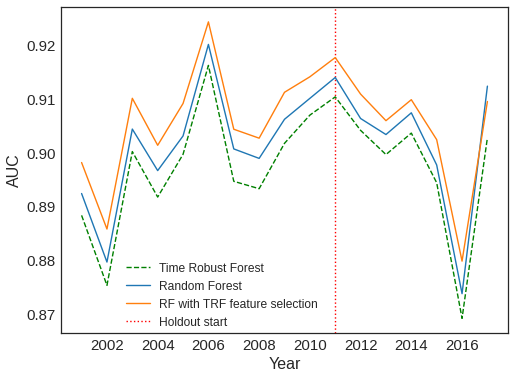

In [95]:
fig, ax = plt.subplots(figsize=(8, 6))
pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["challenger_prediction"])).plot(label="Time Robust Forest", 
                                                                                                      linestyle="dashed",
                                                                                                      color="green", ax=ax)
pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["benchmark_prediction_opt"])).plot(label="Random Forest", ax=ax)

pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["benchmark_prediction_opt_selected_features"])).plot(label="RF with TRF feature selection", ax=ax)


ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)

xmin, xmax, ymin, ymax = plt.axis()
plt.vlines(training_end_year + 1, ymin, ymax, linestyle="dotted", color="red", label="Holdout start")
plt.ylim([ymin, ymax])
plt.legend(fontsize=12, bbox_to_anchor=(0.12, 0.25))
plt.ylabel("AUC", fontsize=16)
plt.xlabel("Year", fontsize=16)
plt.savefig("../images/{}_test_holdout_auc_years_square_fs.eps".format(PREFIX), format="eps")
plt.show()

## Feature Impact

In [76]:
from pygam import LinearGAM
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from matplotlib.collections import PolyCollection as p

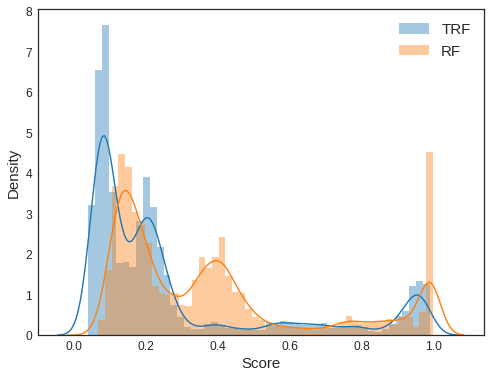

In [77]:
fig, ax = plt.subplots()

sns.distplot(out_of_time["challenger_prediction"], label="TRF")
sns.distplot(out_of_time["benchmark_prediction_opt"], label="RF")

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)

plt.legend(fontsize=15, bbox_to_anchor=(1.0, 1.0))
plt.ylabel("Density", fontsize=15)
plt.xlabel("Score", fontsize=15)

__file__ = "../images/{}_trf_rf_score_distribution".format(PREFIX)
plt.savefig(__file__+".jpg", quality=95)
for c in ax.findobj(p):
    c.set_zorder(-1)
    c.set_rasterized(True)
ax.set_rasterization_zorder(0)

ax.set_rasterized(True)
plt.savefig(__file__+".eps")        

plt.savefig("../images/{}_trf_rf_score_distribution.eps".format(PREFIX), format="eps")
plt.show()

In [78]:
ss = StandardScaler()
out_of_time["challenger_prediction_norm"] = ss.fit_transform(out_of_time[["challenger_prediction"]])
out_of_time["benchmark_prediction_norm"] = ss.fit_transform(out_of_time[["benchmark_prediction_opt"]])

<AxesSubplot:xlabel='benchmark_prediction_norm', ylabel='Density'>

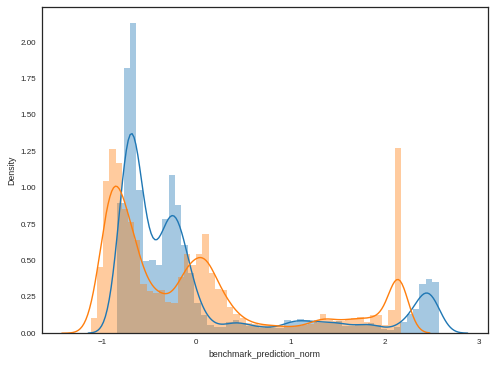

In [79]:
sns.distplot(out_of_time["challenger_prediction_norm"])
sns.distplot(out_of_time["benchmark_prediction_norm"])

In [80]:
X_train, X_test, y_train, y_test = train_test_split(out_of_time[features], 
                                                    out_of_time[["challenger_prediction", 
                                                                 "benchmark_prediction"]],
                                                    test_size=0.6,
                                                    random_state=42)

print(X_train.shape)
print(X_test.shape)

(36173, 13)
(54261, 13)


In [81]:
numerical_features = [feature for feature in features if feature not in columns_to_label_encode]
numerical_features

['Latitude', 'Longitude', 'Beat', 'District', 'Ward', 'Community Area']

In [82]:
p99 = X_train[numerical_features].quantile(.99)
p01 = X_train[numerical_features].quantile(.01)
p005 = X_train.quantile(.005)

X_train[numerical_features] = X_train[numerical_features].where(
    X_train[numerical_features] < p99, other=p99, axis=1)
X_test[numerical_features] = X_test[numerical_features].where(
    X_test[numerical_features] < p99, other=p99, axis=1)

X_train[numerical_features] = X_train[numerical_features].where(
    X_train[numerical_features] > p01, other=p01, axis=1)
X_test[numerical_features] = X_test[numerical_features].where(
    X_test[numerical_features] > p01, other=p01, axis=1)

X_train = X_train.fillna(p005)
X_test = X_test.fillna(p005)

In [83]:
dtype = ["numerical" if feature not in columns_to_label_encode else "categorical" for feature in features]

gam_challenger = LinearGAM(dtype=dtype).gridsearch(X_train[features].values, y_train["challenger_prediction"].values)
gam_benchmark = LinearGAM(dtype=dtype).gridsearch(X_train[features].values, y_train["benchmark_prediction"].values)

100% (11 of 11) |########################| Elapsed Time: 0:00:21 Time:  0:00:21
100% (11 of 11) |########################| Elapsed Time: 0:00:21 Time:  0:00:21


In [85]:
# pred_test = gam_challenger.predict(X_test[features])
# print("r2 test (challenger): %f" %r2_score(y_test["challenger_prediction"], pred_test))

# pred_test = gam_benchmark.predict(X_test[features])
# print("r2 test (benchmark): %f" %r2_score(y_test["benchmark_prediction"], pred_test))

In [90]:
X_test.describe()

,Primary Type,Description,Location Description,FBI Code,Zone,Address,Latitude,Longitude,Beat,District,Ward,Community Area,Domestic
count,54261.000000,54261.000000,54261.000000,54261.000000,54261.000000,54261.000000,54261.000000,54261.000000,54261.000000,54261.000000,54261.000000,54261.000000,54261.000000
mean,14.485321,180.102928,88.036435,11.878771,2.964634,1329.004589,40.913475,-87.671346,1160.851053,11.272184,22.855052,37.680673,0.147638
std,11.425493,101.867070,36.720668,6.492109,0.886865,684.478974,6.236423,0.057255,693.730954,6.899330,13.759066,21.541698,0.354744
min,0.000000,1.000000,0.000000,0.000000,1.000000,3.000000,-1.000000,-87.806965,113.000000,1.000000,1.000000,1.000000,0.000000
25%,3.000000,115.000000,73.000000,7.000000,2.000000,753.000000,41.764890,-87.713899,614.000000,6.000000,10.000000,23.000000,0.000000
50%,16.000000,219.000000,101.000000,10.000000,3.000000,1336.000000,41.852538,-87.666443,1024.000000,10.000000,23.000000,32.000000,0.000000
75%,27.000000,275.000000,117.000000,16.000000,4.000000,1961.000000,41.904538,-87.628914,1713.000000,17.000000,34.000000,58.000000,0.000000
max,31.000000,329.000000,130.000000,25.000000,4.000000,2445.000000,42.010422,-87.548486,2533.000000,25.000000,49.000000,76.000000,1.000000


Latitude
6


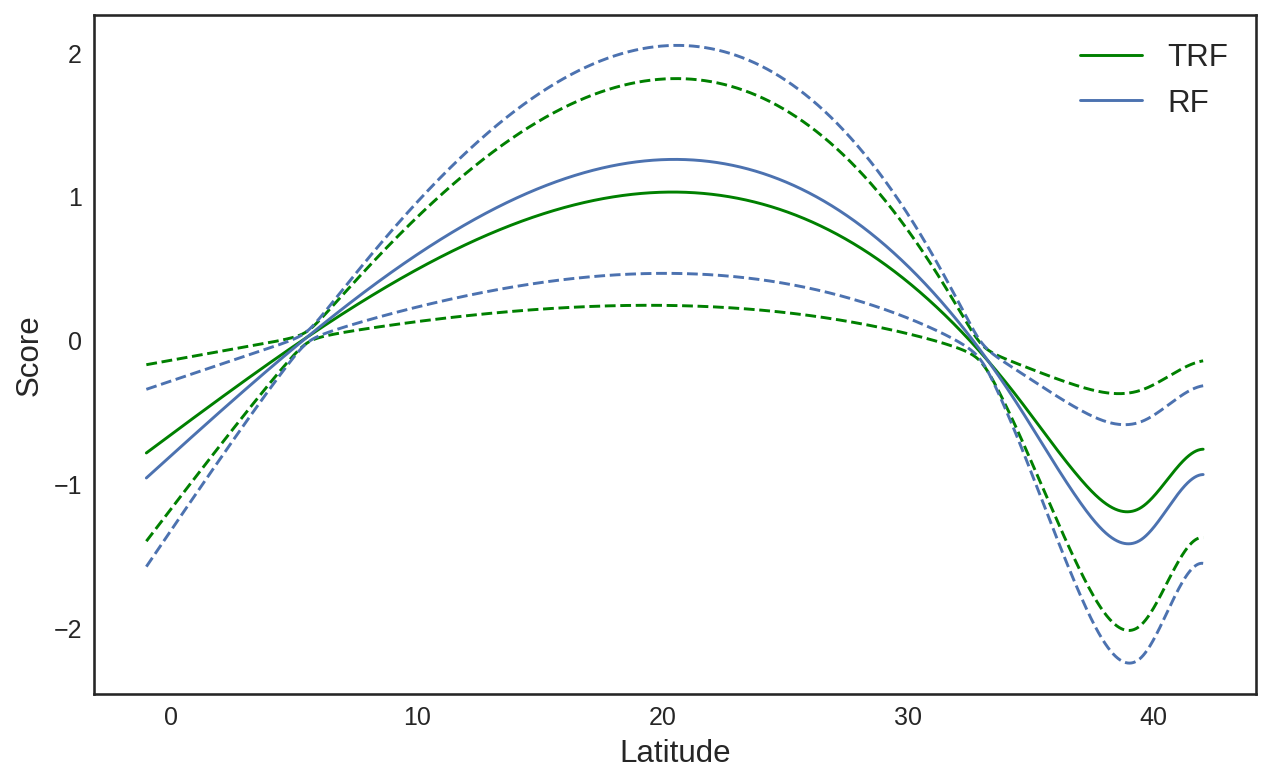

Longitude
7


<Figure size 576x432 with 0 Axes>

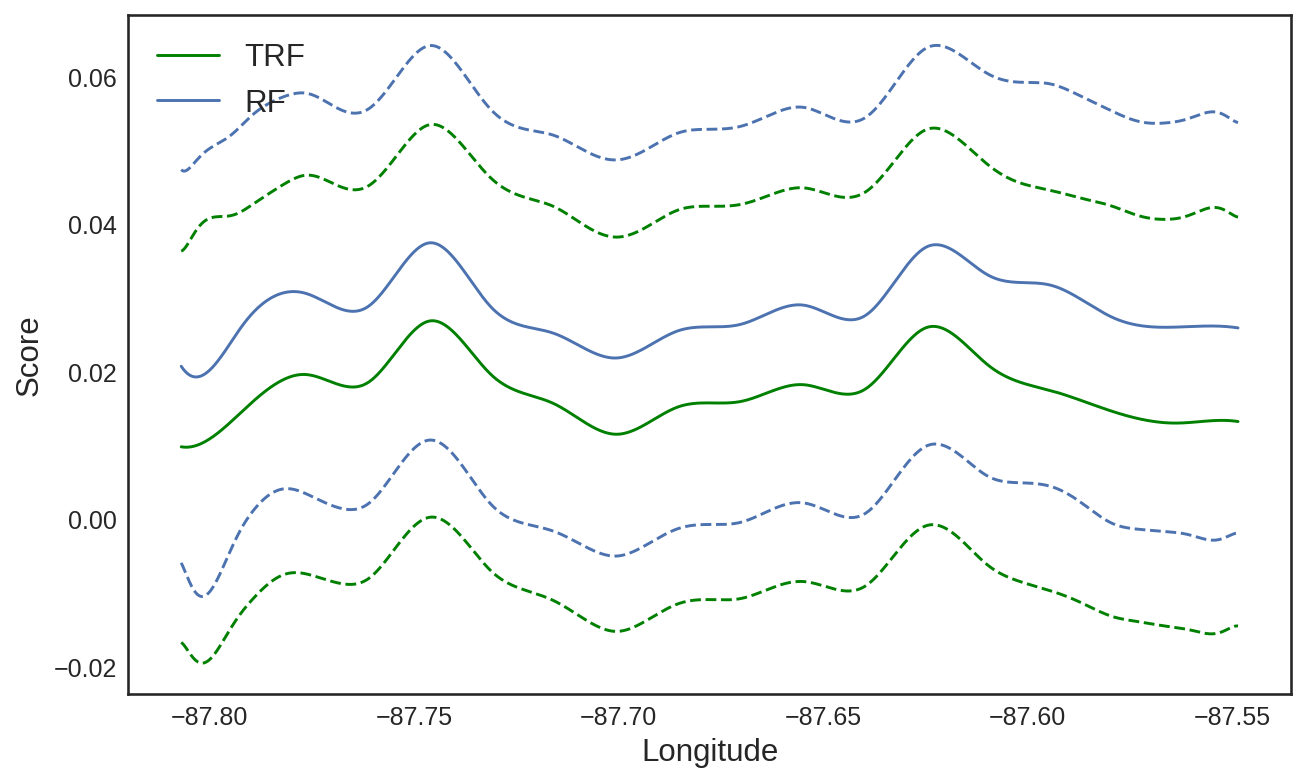

Beat
8


<Figure size 576x432 with 0 Axes>

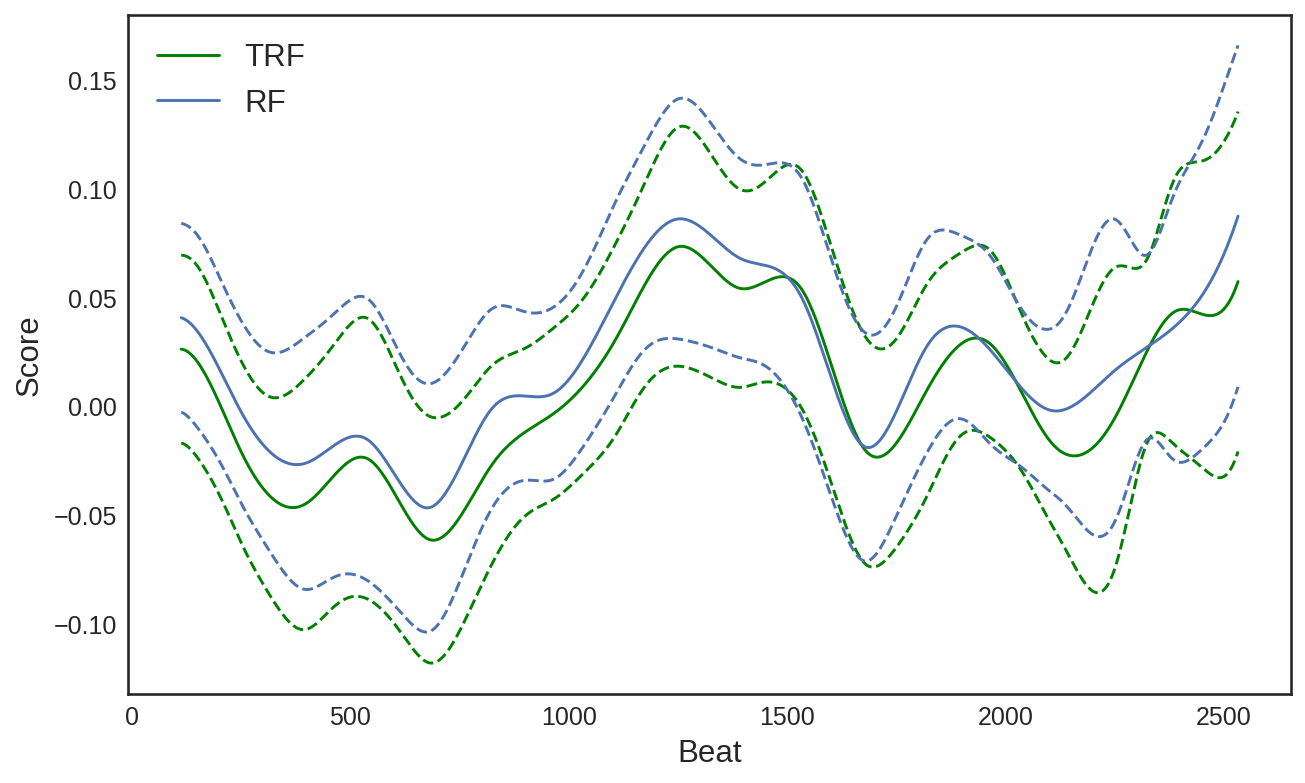

District
9


<Figure size 576x432 with 0 Axes>

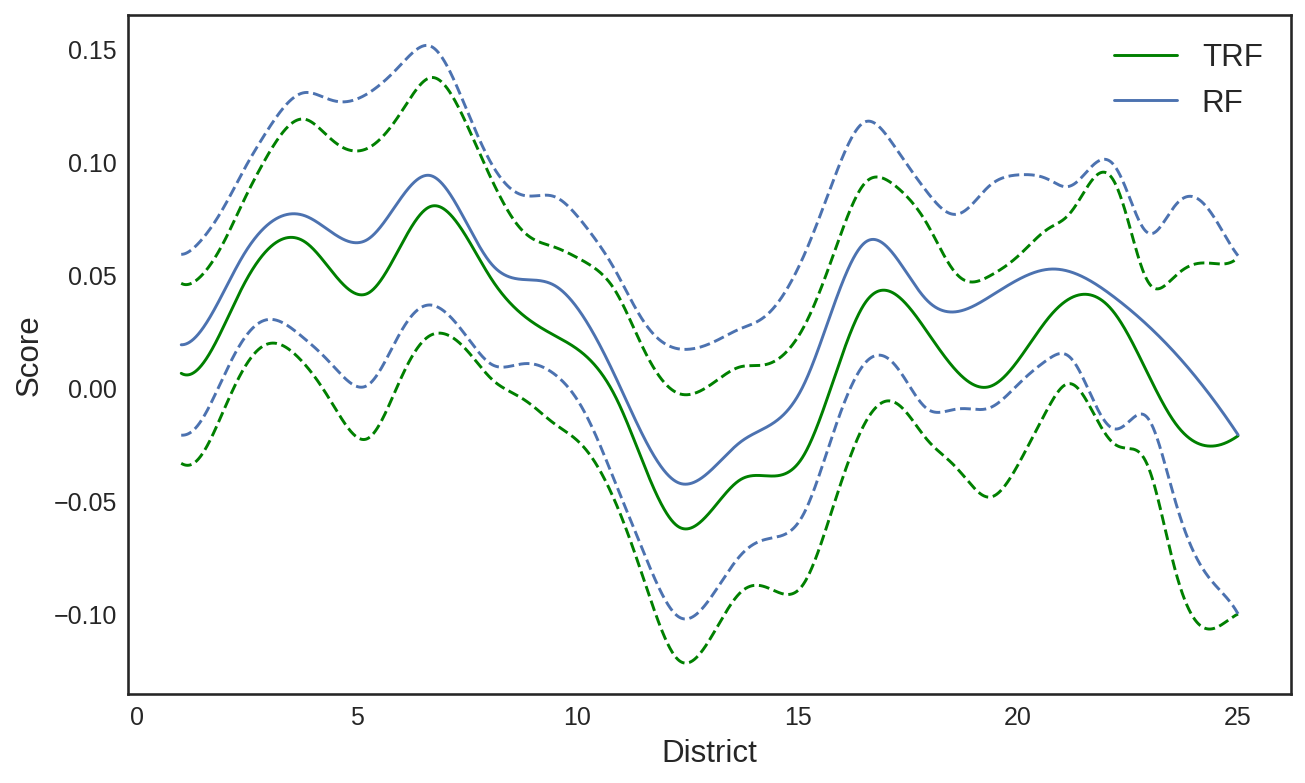

Ward
10


<Figure size 576x432 with 0 Axes>

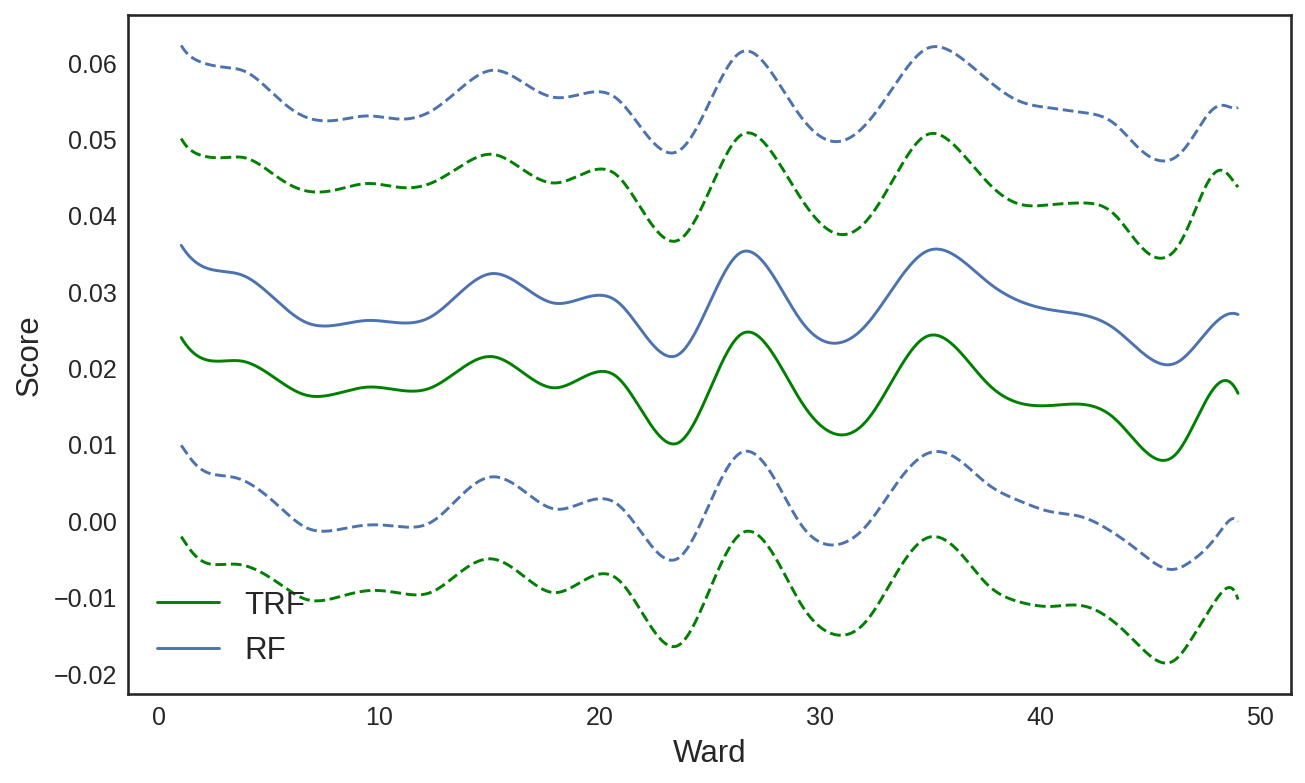

Community Area
11


<Figure size 576x432 with 0 Axes>

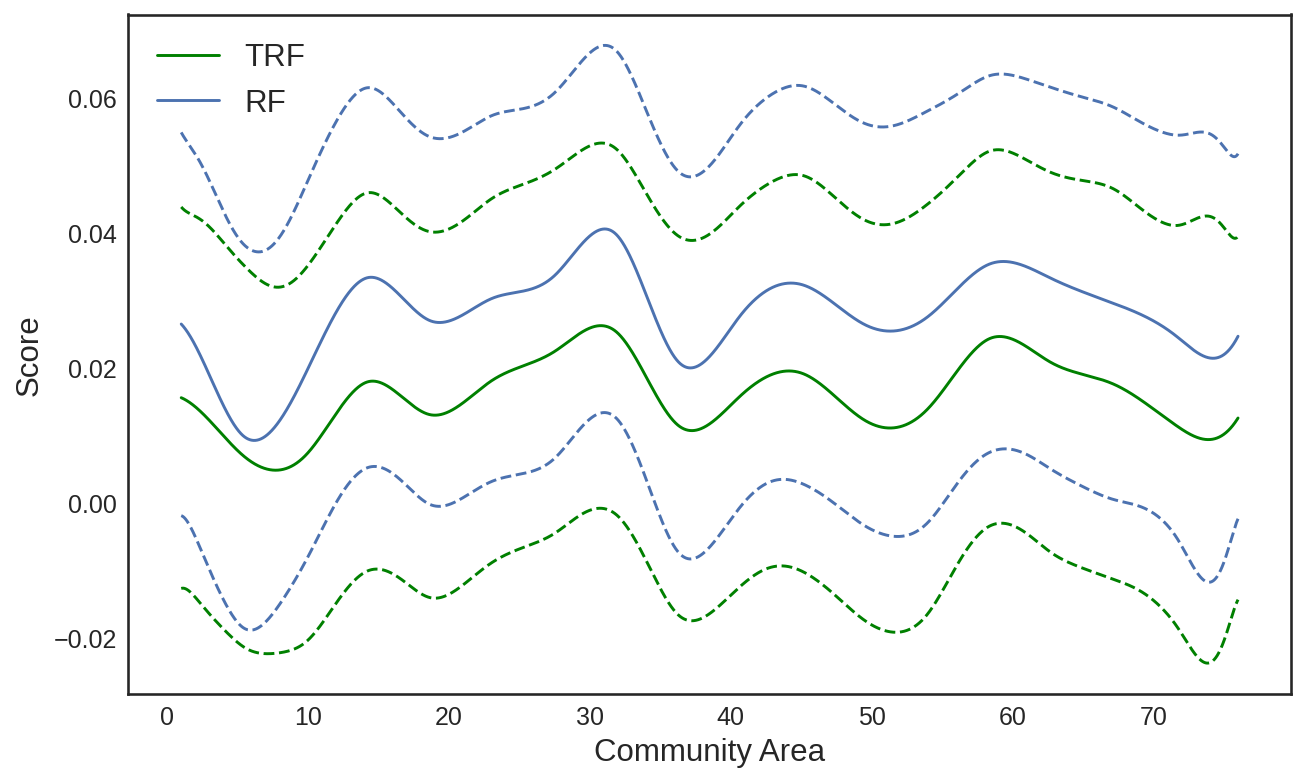

<Figure size 576x432 with 0 Axes>

In [99]:
for i, feat in enumerate(features):
    if feat not in numerical_features:
        continue
    print(feat)
    print(i)
    XX = gam_challenger.generate_X_grid(i, n=X_test.shape[0])
    ### Fix needed for this dataset
    XX[:, 1] = np.where(X_test.values[:, 1].astype(int) >= 329, 328, X_test.values[:, 1].astype(int))
    XX[:, 5] = np.where(X_test.values[:, 5].astype(int) >= 2445, 2444, X_test.values[:, 5].astype(int))
    pdep, confi = gam_challenger.partial_dependence(i, X=XX, width=.95)
    fig, ax = plt.subplots(figsize=(10, 6), dpi=150)

    plt.plot(XX[:, i], pdep, c="green", label="TRF")
    plt.plot(XX[:, i], confi, c='green', ls='--')
    plt.ylabel("Score")
    plt.legend()

    ### Benchmark
    pdep, confi = gam_benchmark.partial_dependence(i, X=XX, width=.95)
    plt.plot(XX[:, i], pdep, color="#4c72b0", label="RF")
    plt.plot(XX[:, i], confi, c='#4c72b0', ls='--')
    plt.ylabel("Score", fontsize=15)
    plt.legend()

    plt.xlabel(feat, fontsize=15)

    ax.xaxis.set_tick_params(labelsize=12)
    ax.yaxis.set_tick_params(labelsize=12)
    xmin, xmax, ymin, ymax = plt.axis()
    plt.ylim([ymin, ymax])
    plt.legend(fontsize=15)
    plt.savefig("../images/{}_feature_impact_{}.eps".format(PREFIX, feat), format="eps")

    plt.show()
    plt.clf()

Primary Type


No handles with labels found to put in legend.


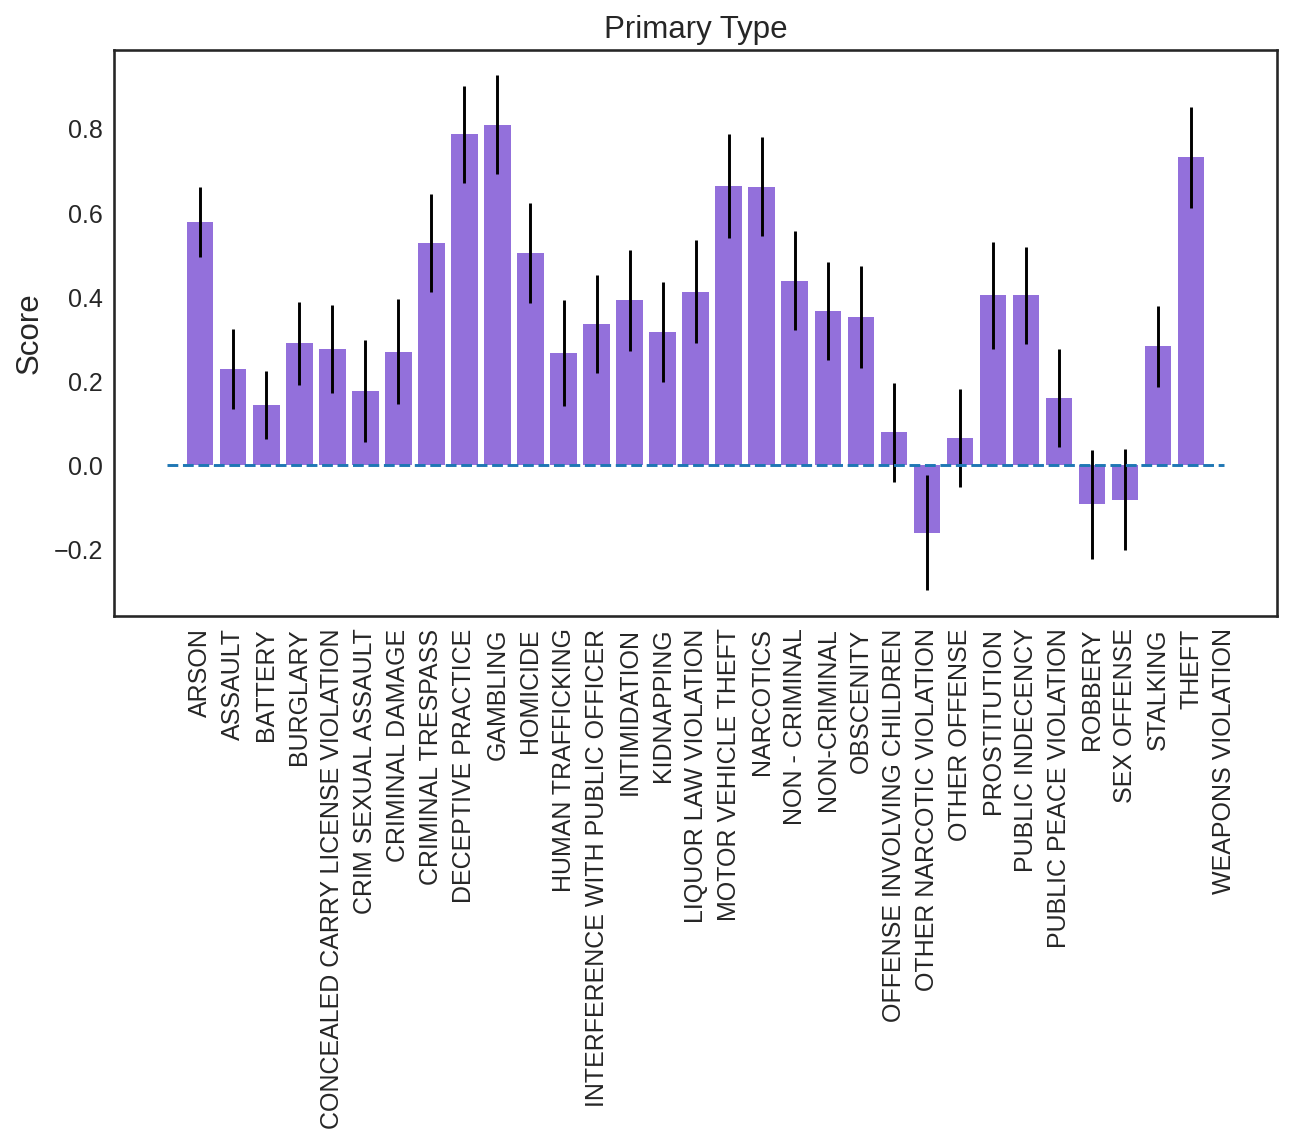

No handles with labels found to put in legend.


Description
Location Description
FBI Code


<Figure size 576x432 with 0 Axes>

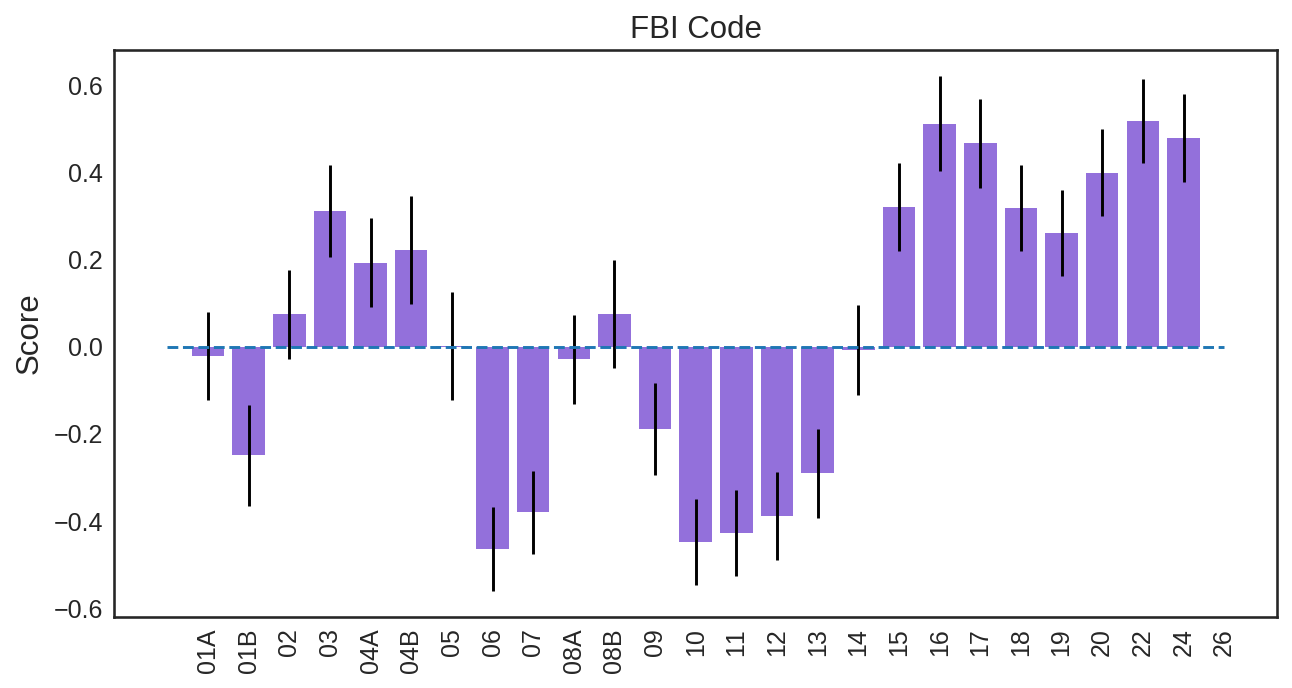

No handles with labels found to put in legend.


Zone


<Figure size 576x432 with 0 Axes>

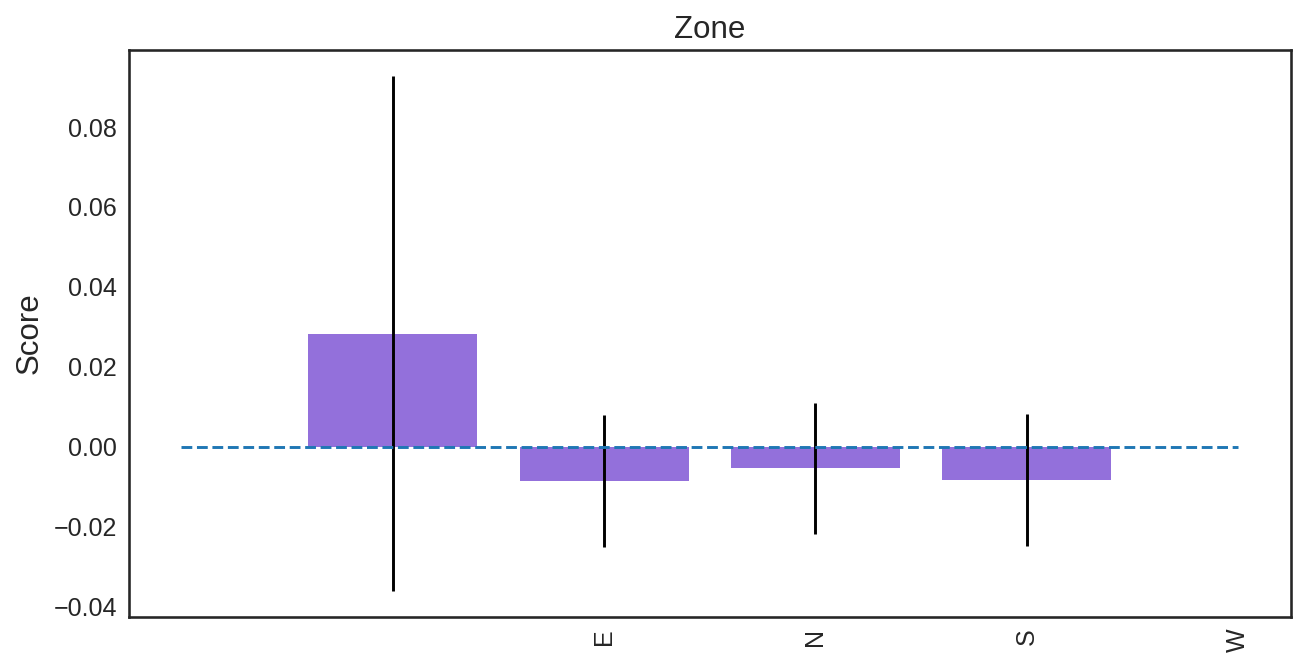

No handles with labels found to put in legend.


Address
Domestic


<Figure size 576x432 with 0 Axes>

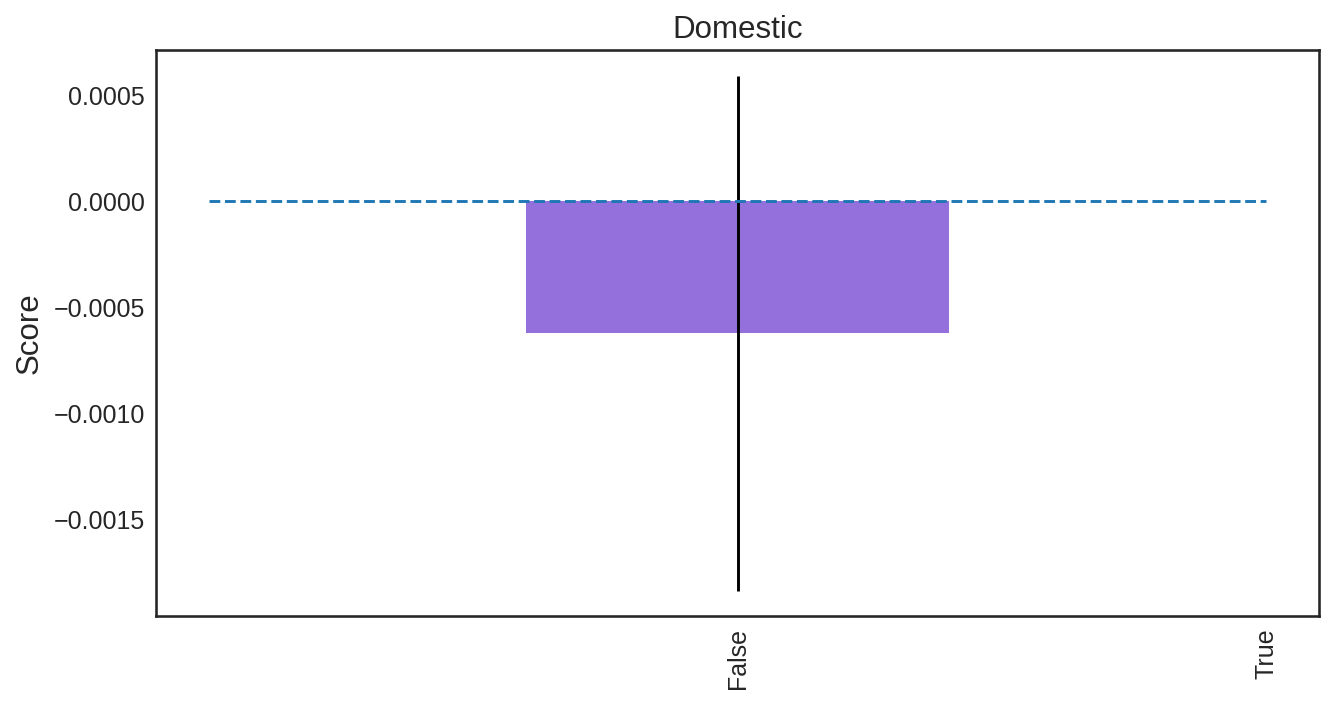

<Figure size 576x432 with 0 Axes>

In [102]:
for i, feat in enumerate(features):
    if feat in columns_to_label_encode:
        print(feat)
        #try:
        mapping = encoder_mappings[feat]
        max_cat = np.max(list(mapping.keys()))
        if max_cat > 100:
            continue
        XX = np.copy(X_test)
        XX[:, i] = np.random.randint(0, max_cat, size=X_test.shape[0])
        XX[:, 1] = np.where(X_test.values[:, 1].astype(int) >= 329, 328, X_test.values[:, 1].astype(int))
        XX[:, 5] = np.where(X_test.values[:, 5].astype(int) >= 2445, 2444, X_test.values[:, 5].astype(int))
        pdep, confi = gam_challenger.partial_dependence(i, X=XX, width=.95)
        fig, ax = plt.subplots(figsize=(10, 5), dpi=150)
        data = pd.DataFrame(np.hstack([XX[:, i].reshape(-1, 1), pdep.reshape(-1, 1), confi]),
                            columns=[feat, "Mean Impact", "low", "high"])
        data["low"] = np.abs(data["low"] - data["Mean Impact"])
        data["high"] = np.abs(data["high"] - data["Mean Impact"])
        agg = data.groupby(feat).mean()

        impact_plot = plt.bar([i for i in range(len(agg))],
                              agg["Mean Impact"],
                              yerr=agg[["low", "high"]].values.transpose(),
                              color="#9370DB",
                              capsize=7)

        plt.title(feat, fontsize=15)
        plt.xticks([i for i in range(len(list(mapping.keys())))])
        ax.set_xticklabels(list(mapping.values()), rotation=90)
        plt.hlines(0.0, -1, max_cat, linestyles="dashed")
        plt.ylabel("Score", fontsize=15)

        ax.xaxis.set_tick_params(labelsize=12)
        ax.yaxis.set_tick_params(labelsize=12)
        xmin, xmax, ymin, ymax = plt.axis()
        plt.ylim([ymin, ymax])
        plt.legend(fontsize=15)
        plt.savefig("../images/{}_feature_impact_cat_{}.eps".format(PREFIX, feat), format="eps")

        plt.show()
        plt.clf()
#         except:
#             print("No plot for {}".format(feat))
plt.show()

Primary Type


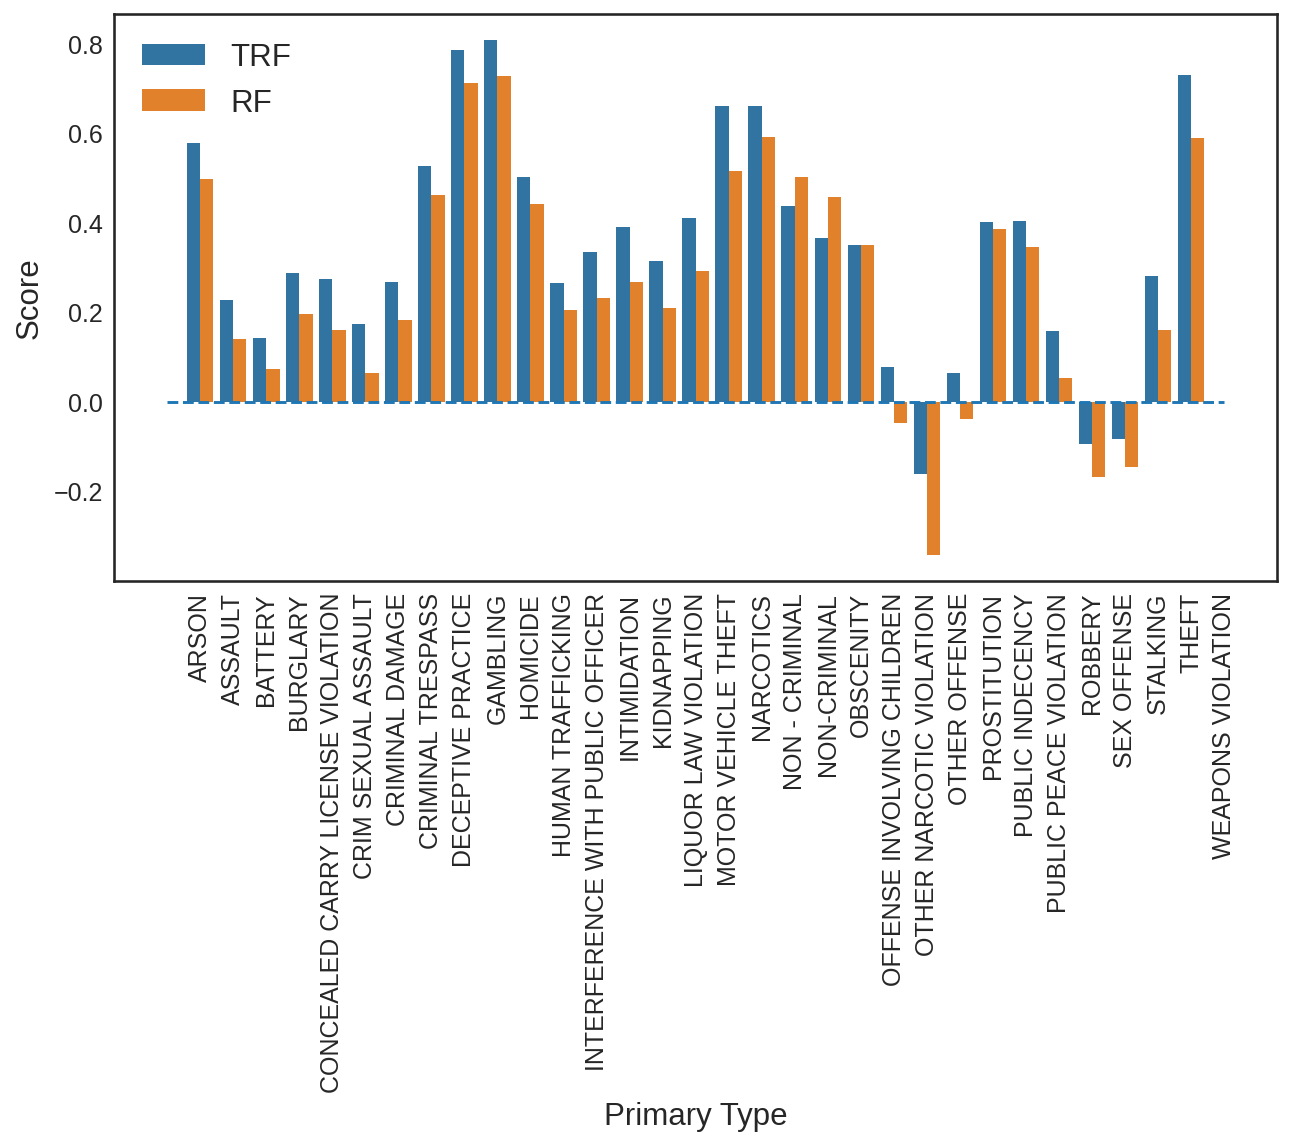

Description
Location Description
FBI Code


<Figure size 576x432 with 0 Axes>

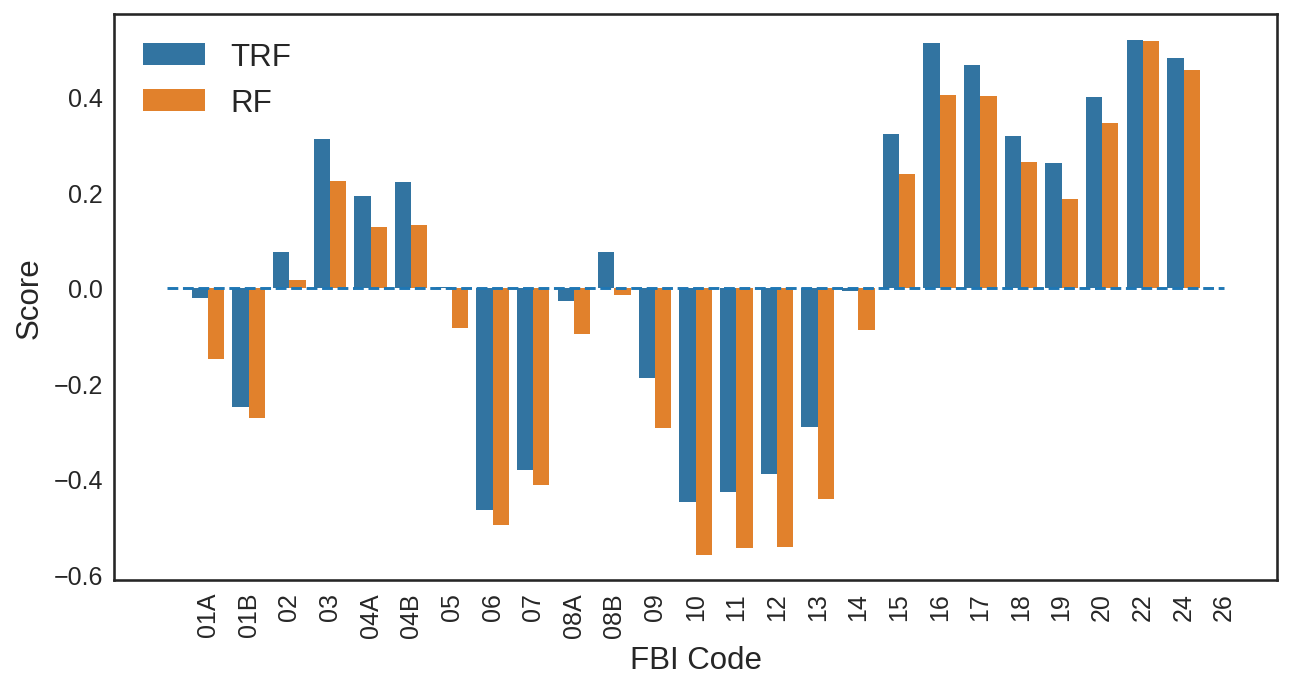

Zone


<Figure size 576x432 with 0 Axes>

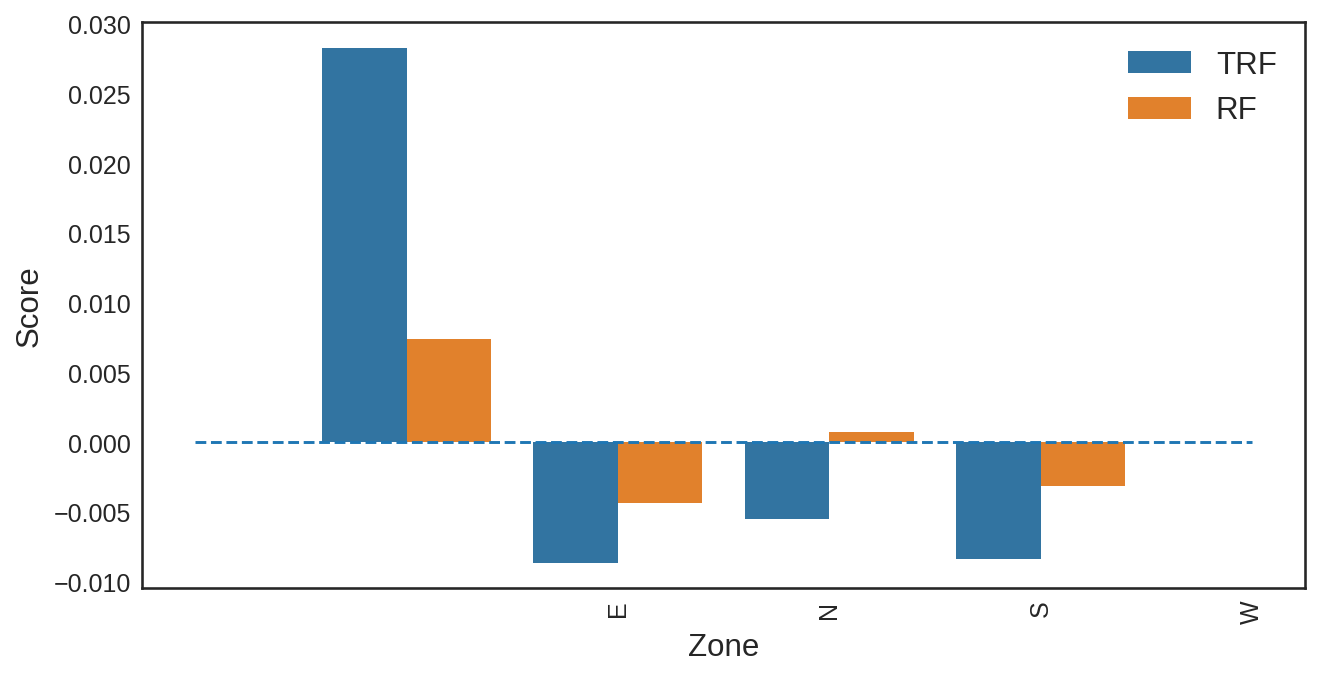

Address
Domestic


<Figure size 576x432 with 0 Axes>

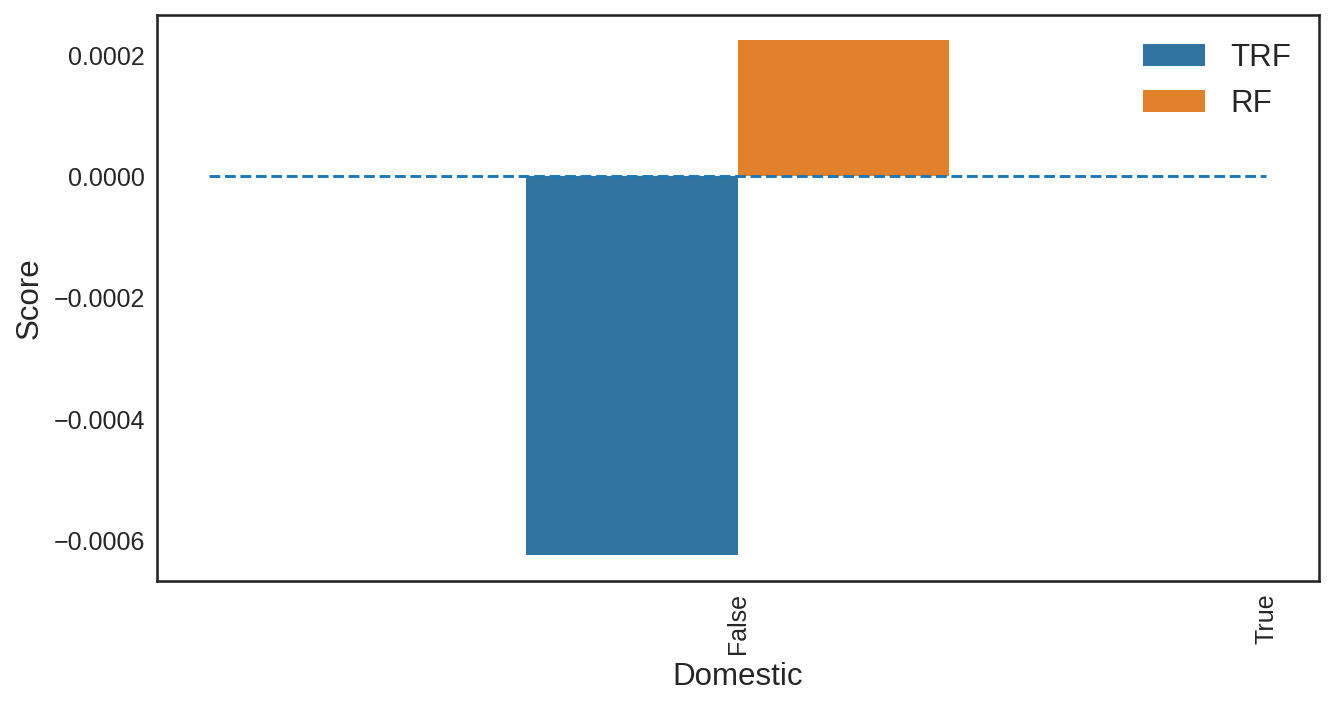

<Figure size 576x432 with 0 Axes>

In [103]:
for i, feat in enumerate(features):
    if feat in columns_to_label_encode:
        print(feat)
        mapping = encoder_mappings[feat]
        max_cat = np.max(list(mapping.keys()))
        if max_cat > 100:
            continue
        XX = np.copy(X_test)
        XX[:, i] = np.random.randint(0, max_cat, size=X_test.shape[0])
        XX[:, 1] = np.where(X_test.values[:, 1].astype(int) >= 329, 328, X_test.values[:, 1].astype(int))
        XX[:, 5] = np.where(X_test.values[:, 5].astype(int) >= 2445, 2444, X_test.values[:, 5].astype(int))

        ### Challenger
        pdep, confi = gam_challenger.partial_dependence(i, X=XX, width=.95)
        fig, ax = plt.subplots(figsize=(10, 5), dpi=150)
        data = pd.DataFrame(np.hstack([XX[:, i].reshape(-1, 1), pdep.reshape(-1, 1), confi]),
                            columns=[feat, "Mean Impact", "low", "high"])
        data["low"] = np.abs(data["low"] - data["Mean Impact"])
        data["high"] = np.abs(data["high"] - data["Mean Impact"])
        data["model"] = "TRF"
        agg = data.groupby(feat).mean()


        ### Benchmark
        pdep, confi = gam_benchmark.partial_dependence(i, X=XX, width=.95)
        data_benchmark = pd.DataFrame(np.hstack([XX[:, i].reshape(-1, 1), pdep.reshape(-1, 1), confi]),
                            columns=[feat, "Mean Impact", "low", "high"])
        data_benchmark["low"] = np.abs(data_benchmark["low"] - data_benchmark["Mean Impact"])
        data_benchmark["high"] = np.abs(data_benchmark["high"] - data_benchmark["Mean Impact"])
        data_benchmark["model"] = "RF"
        
        data = pd.concat([data, data_benchmark])
        agg = data.groupby(feat).mean()
        
        sns.barplot(data=data, x=feat, y="Mean Impact", hue="model")


        plt.xticks([i for i in range(len(list(mapping.keys())))])
        ax.set_xticklabels(list(mapping.values()), rotation=90)
        plt.hlines(0.0, -1, max_cat, linestyles="dashed")
        plt.ylabel("Score", fontsize=15)
        
        ax.xaxis.set_tick_params(labelsize=12)
        ax.yaxis.set_tick_params(labelsize=12)
        xmin, xmax, ymin, ymax = plt.axis()
        plt.ylim([ymin, ymax])
        plt.legend(fontsize=15)
        plt.xlabel(feat, fontsize=15)
        plt.savefig("../images/{}_feature_impact_cat_comparison_{}.eps".format(PREFIX, feat), format="eps")
        
        plt.show()
        plt.clf()

## Minimum samples by period effect

In [104]:
target = TARGET
min_sample_periods_values = [1, 5, 10, 20, 50, 100, 250, 500]

In [105]:
min_sample_knob = {}
min_sample_knob["challenger"] = {"unseen_performance": [], "train_performance": [],
                                "test_performance": [], "unseen_performance_by_period": []}
unseen_performance = []
train_performance = []
test_performance = []
unseen_performance_by_period = []

for min_sample_periods in min_sample_periods_values:
    model_split_time = TimeForestClassifier(time_column=TIME_COLUMN,
                                        n_estimators=CHALLENGER_N_ESTIMATORS,
                                        min_sample_periods=min_sample_periods,
                                        max_depth=CHALLENGER_MAX_DEPTH,
                                        multi=True)
    
    model_split_time.fit(train[features + [TIME_COLUMN]], train[target])
    out_of_time["time_split_prediction"] = model_split_time.predict_proba(out_of_time[features])[:, 1]
    
    performance = metrics.roc_auc_score(out_of_time[target], out_of_time["time_split_prediction"])
    min_sample_knob["challenger"]["unseen_performance"].append(performance)
    min_sample_knob["challenger"]["unseen_performance_by_period"].append(out_of_time.groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[target], x["time_split_prediction"])))

    train["time_split_prediction"] = model_split_time.predict(train[features])
    min_sample_knob["challenger"]["train_performance"].append(metrics.roc_auc_score(train[target], train["time_split_prediction"]))
    
    test["time_split_prediction"] = model_split_time.predict(test[features])
    min_sample_knob["challenger"]["test_performance"].append(metrics.roc_auc_score(test[target], test["time_split_prediction"]))

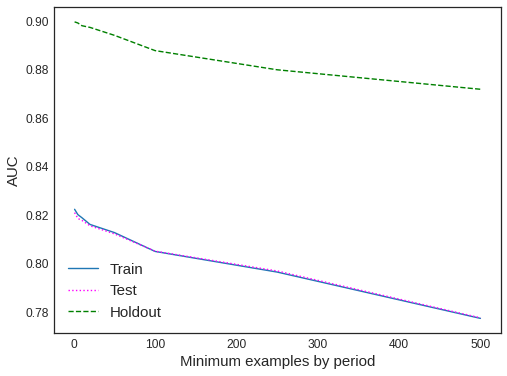

In [106]:
fig, ax = plt.subplots()
plt.plot(min_sample_periods_values, min_sample_knob["challenger"]["train_performance"], label="Train")
plt.plot(min_sample_periods_values, min_sample_knob["challenger"]["test_performance"], label="Test", 
         color="magenta",
         linestyle="dotted")
plt.plot(min_sample_periods_values, min_sample_knob["challenger"]["unseen_performance"], label="Holdout", 
                                                         linestyle="dashed",
                                                         color="green")

#plt.title("Holdout AUC by minimum examples by period parameter", fontsize=15)
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
xmin, xmax, ymin, ymax = plt.axis()
plt.ylim([ymin, ymax])
plt.legend(fontsize=15)
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Minimum examples by period", fontsize=15)
plt.savefig("../images/{}_test_min_example_by_period_train_and_holdout_whole.eps".format(PREFIX), format="eps")
plt.show()

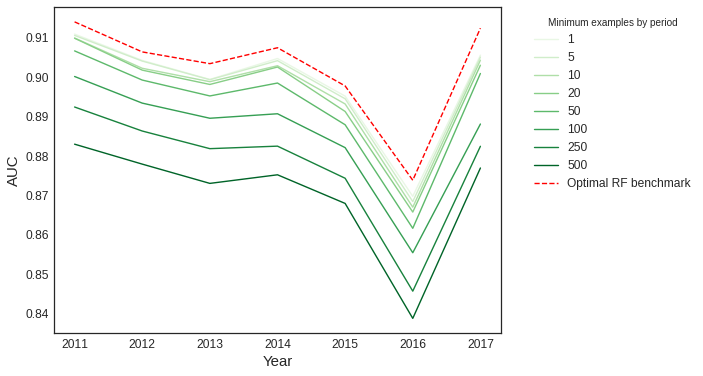

In [107]:
fig, ax = plt.subplots()

greens = plt.get_cmap("Greens")
gradient = np.linspace(.1, 0.9, len(min_sample_periods_values))
for i, experiment in enumerate(min_sample_knob["challenger"]["unseen_performance_by_period"]):
    experiment.plot(label=min_sample_periods_values[i], color=greens(gradient[i]))

out_of_time.groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[target], x["benchmark_prediction_opt"])).plot(label="Optimal RF benchmark", 
                                                                                                 color="red", linestyle="dashed", ax=ax)
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(bbox_to_anchor=(1.05, 1.0), fontsize=12, title="Minimum examples by period")
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Year", fontsize=15)

x_labels = np.sort(out_of_time[TIME_COLUMN].unique())
plt.xticks(x_labels)

plt.savefig("../images/{}_holdout_dif_min_samples.eps".format(PREFIX), format="eps", bbox_inches = "tight")
plt.show()

In [108]:
min_sample_knob["benchmark"] = {"unseen_performance": [], "train_performance": [],
                                "test_performance": [], "unseen_performance_by_period": []}

training_segments = train[TIME_COLUMN].nunique()
for min_sample_periods in min_sample_periods_values:

    model = tuned_rf
    model.set_params(min_samples_leaf=training_segments * min_sample_periods)
    
    
    model.fit(train[features],
              train[TARGET])
     
    out_of_time["time_split_prediction"] = model.predict_proba(out_of_time[features])[:, 1]
    
    performance = metrics.roc_auc_score(out_of_time[target], out_of_time["time_split_prediction"])
    min_sample_knob["benchmark"]["unseen_performance"].append(performance)
    min_sample_knob["benchmark"]["unseen_performance_by_period"].append(out_of_time.groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[target], x["time_split_prediction"])))

    train["time_split_prediction"] = model.predict(train[features])
    min_sample_knob["benchmark"]["train_performance"].append(metrics.roc_auc_score(train[target], train["time_split_prediction"]))
    
    test["time_split_prediction"] = model.predict(test[features])
    min_sample_knob["benchmark"]["test_performance"].append(metrics.roc_auc_score(test[target], test["time_split_prediction"]))

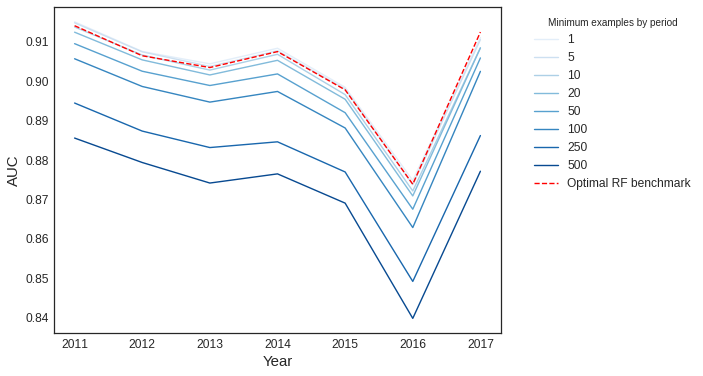

In [109]:
fig, ax = plt.subplots()

blues = plt.get_cmap("Blues")
for i, experiment in enumerate(min_sample_knob["benchmark"]["unseen_performance_by_period"]):
    experiment.plot(label=min_sample_periods_values[i], color=blues(gradient[i]))

out_of_time.groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[target], x["benchmark_prediction_opt"])).plot(label="Optimal RF benchmark", 
                                                                                                 color="red", linestyle="dashed", ax=ax)

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(bbox_to_anchor=(1.05, 1.0), fontsize=12, title="Minimum examples by period")
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Year", fontsize=15)

x_labels = np.sort(out_of_time[TIME_COLUMN].unique())
plt.xticks(x_labels)

plt.savefig("../images/{}_holdout_dif_min_samples_benchmark.eps".format(PREFIX), format="eps", bbox_inches = "tight")
plt.show()

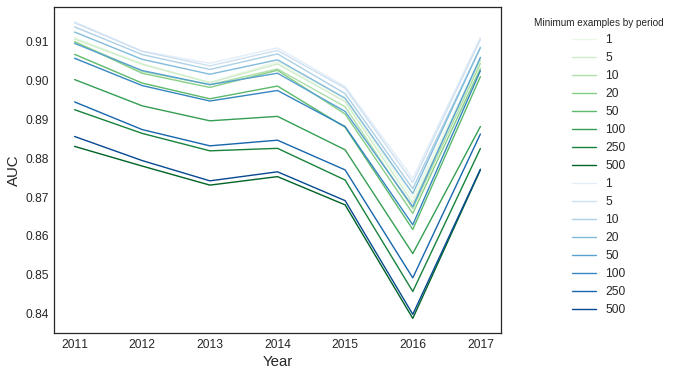

In [110]:
fig, ax = plt.subplots()
for i, experiment in enumerate(min_sample_knob["challenger"]["unseen_performance_by_period"]):
    experiment.plot(label=min_sample_periods_values[i], color=greens(gradient[i]))
    
for i, experiment in enumerate(min_sample_knob["benchmark"]["unseen_performance_by_period"]):
    experiment.plot(label=min_sample_periods_values[i], color=blues(gradient[i]))    

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(bbox_to_anchor=(1.05, 1.0), fontsize=12, title="Minimum examples by period")
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Year", fontsize=15)

x_labels = np.sort(out_of_time[TIME_COLUMN].unique())
plt.xticks(x_labels)

plt.savefig("../images/{}_holdout_dif_min_samples_benchmark_challenger.eps".format(PREFIX), format="eps", bbox_inches = "tight")
plt.show()

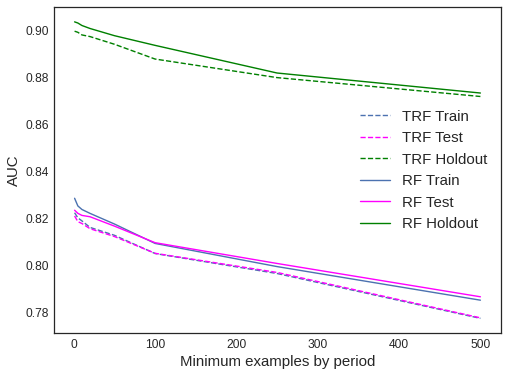

In [111]:
fig, ax = plt.subplots()
plt.plot(min_sample_periods_values, min_sample_knob["challenger"]["train_performance"], label="TRF Train",
        color="#4c72b0", linestyle="dashed")
plt.plot(min_sample_periods_values, min_sample_knob["challenger"]["test_performance"], label="TRF Test", 
         color="magenta",
         linestyle="dashed")
plt.plot(min_sample_periods_values, min_sample_knob["challenger"]["unseen_performance"], label="TRF Holdout", 
                                                         linestyle="dashed",
                                                         color="green")

plt.plot(min_sample_periods_values, min_sample_knob["benchmark"]["train_performance"], label="RF Train",
        color="#4c72b0")
plt.plot(min_sample_periods_values, min_sample_knob["benchmark"]["test_performance"], label="RF Test", 
         color="magenta")
plt.plot(min_sample_periods_values, min_sample_knob["benchmark"]["unseen_performance"], label="RF Holdout", 
                                                         color="green")

#plt.title("Holdout AUC by minimum examples by period parameter", fontsize=15)
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
xmin, xmax, ymin, ymax = plt.axis()
plt.ylim([ymin, ymax])
plt.legend(fontsize=15)
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Minimum examples by period", fontsize=15)
plt.savefig("../images/{}_test_min_example_by_period_train_and_holdout_whole_bench_challenger.eps".format(PREFIX), format="eps")
plt.show()

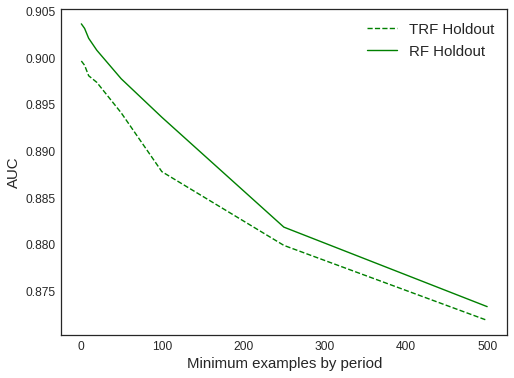

In [112]:
fig, ax = plt.subplots()

plt.plot(min_sample_periods_values, min_sample_knob["challenger"]["unseen_performance"], label="TRF Holdout", 
                                                         linestyle="dashed",
                                                         color="green")

plt.plot(min_sample_periods_values, min_sample_knob["benchmark"]["unseen_performance"], label="RF Holdout", 
                                                         color="green")

#plt.title("Holdout AUC by minimum examples by period parameter", fontsize=15)
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
xmin, xmax, ymin, ymax = plt.axis()
plt.ylim([ymin, ymax])
plt.legend(fontsize=15)
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Minimum examples by period", fontsize=15)
plt.savefig("../images/{}_holdout_min_example_by_period_train_and_holdout_whole_bench_challenger.eps".format(PREFIX), format="eps")
plt.show()

## Domain classifier

In [113]:
train["domain"] = 1
test["domain"] = 1
out_of_time["domain"] = 0

In [114]:
domain_data = pd.concat([train, test, out_of_time])

In [115]:
train_domain, test_domain = train_test_split(domain_data, 
                               test_size=0.2,
                               random_state=42)

In [116]:
clf2 = setup(train_domain[features + ["domain"]], target="domain",
             session_id=124, 
             log_experiment=False, 
             experiment_name="{}_domain".format(PREFIX),
             silent=True)

rf = create_model('rf')
tuned_domain_rf = tune_model(rf,
                             optimize="AUC",
                             fold=5,
                             n_iter=50)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.4906,0.6828,0.3896,0.8876,0.5416,0.1332,0.1971
1,0.5030,0.6803,0.4139,0.8778,0.5626,0.1340,0.1906
2,0.5057,0.6822,0.4164,0.8806,0.5654,0.1381,0.1960
3,0.4889,0.6847,0.3881,0.8859,0.5397,0.1308,0.1938
4,0.4823,0.6882,0.3736,0.8945,0.5271,0.1322,0.2012
Mean,0.4941,0.6836,0.3963,0.8853,0.5473,0.1337,0.1957
SD,0.0089,0.0027,0.0164,0.0058,0.0146,0.0024,0.0035


In [117]:
domain_model = tuned_domain_rf

In [118]:
domain_model.fit(train_domain[features], train_domain["domain"])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='gini',
                       max_depth=9, max_features='sqrt', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0,
                       min_impurity_split=None, min_samples_leaf=5,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=200, n_jobs=-1, oob_score=False,
                       random_state=124, verbose=0, warm_start=False)

In [119]:
test_domain["pred_domain"] = domain_model.predict_proba(test_domain[features])[:, 1]

In [120]:
roc_auc_score(test_domain["domain"], test_domain["pred_domain"])

0.6882707888830806

## Other optimization design for the RF

In [44]:
last_time_segment_in_train = np.max(in_time[TIME_COLUMN].unique())
last_time_segment_in_train

2010

In [45]:
posfix = str(last_time_segment_in_train)

In [46]:
new_train = in_time[in_time["Year"] < last_time_segment_in_train]
new_validation = in_time[in_time["Year"] == last_time_segment_in_train]

In [ ]:
clf1 = setup(new_train[features + [TARGET]], target=TARGET,
             test_data=new_validation,
             session_id=44,
             log_experiment=False,
             experiment_name="{}_opt1".format(PREFIX),
             silent=True)

rf = create_model('rf')
tuned_rf = tune_model(rf,
                      optimize="AUC",
                      n_iter=25)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8682,0.8904,0.6857,0.8346,0.7528,0.6642,0.6702
1,0.8724,0.8941,0.6911,0.8447,0.7602,0.6744,0.6808
2,0.8723,0.8960,0.6947,0.8414,0.7611,0.6750,0.6808
3,0.8689,0.8940,0.6840,0.8382,0.7533,0.6652,0.6716
4,0.8687,0.8917,0.6851,0.8368,0.7534,0.6652,0.6714
5,0.8684,0.8948,0.6878,0.8337,0.7537,0.6651,0.6708
6,0.8709,0.8938,0.6898,0.8406,0.7578,0.6709,0.6770
7,0.8736,0.8950,0.6892,0.8505,0.7614,0.6767,0.6836
8,0.8709,0.8934,0.6889,0.8415,0.7576,0.6708,0.6771
9,0.8753,0.8963,0.6980,0.8490,0.7661,0.6822,0.6882


IntProgress(value=0, description='Processing: ', max=7)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,10:41:35
Status,. . . . . . . . . . . . . . . . . .,Searching Hyperparameters
Estimator,. . . . . . . . . . . . . . . . . .,Random Forest Classifier


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC


Fitting 10 folds for each of 25 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  3.4min


In [ ]:
tuned_rf

In [ ]:
benchmark_model = tuned_rf
benchmark_model.fit(train[features], train[TARGET])

train["benchmark_prediction_opt_{}".format(posfix)] = benchmark_model.predict_proba(train[features])[:, 1]
test["benchmark_prediction_opt_{}".format(posfix)] = benchmark_model.predict_proba(test[features])[:, 1]
out_of_time["benchmark_prediction_opt_{}".format(posfix)] = benchmark_model.predict_proba(out_of_time[features])[:, 1]

In [ ]:
new_validation, add_to_train = train_test_split(new_validation, test_size=0.5)

new_train = pd.concat([new_train, add_to_train])

In [ ]:
clf1 = setup(new_train[features + [TARGET]], target=TARGET,
             test_data=new_validation,
             session_id=22,
             log_experiment=False,
             experiment_name="{}_opt2".format(PREFIX),
             silent=True)

rf = create_model('rf')
tuned_rf = tune_model(rf,
                     optimize="AUC",
                     n_iter=50)

In [ ]:
benchmark_model = tuned_rf
benchmark_model.fit(train[features], train[TARGET])

train["benchmark_prediction_opt_half_{}".format(posfix)] = benchmark_model.predict_proba(train[features])[:, 1]
test["benchmark_prediction_opt_half_{}".format(posfix)] = benchmark_model.predict_proba(test[features])[:, 1]
out_of_time["benchmark_prediction_opt_half_{}".format(posfix)] = benchmark_model.predict_proba(out_of_time[features])[:, 1]

In [ ]:
fig, ax = plt.subplots()
pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["challenger_prediction"])).plot(label="Time Robust Forest", 
                                                                                                      linestyle="dashed",
                                                                                                      color="green", ax=ax)

pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["benchmark_prediction_opt_half_{}".format(posfix)])).plot(label="RF: Half {} in validation".format(posfix), 
                                                                                                      #linestyle="dashed",
                                                                                                      color="purple", ax=ax)
pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["benchmark_prediction_opt"])).plot(label="RF: K-fold in the in-time", ax=ax)
pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["benchmark_prediction_opt_{}".format(posfix)])).plot(label="RF: Full {} in validation".format(posfix), ax=ax)

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)

xmin, xmax, ymin, ymax = plt.axis()
plt.vlines(training_end_year + 1, ymin, ymax, linestyle="dotted", color="red", label="Holdout start")
plt.ylim([ymin, ymax])
plt.legend(fontsize=15, bbox_to_anchor=(1.0, 1.0))
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Year", fontsize=15)
plt.savefig("../images/{}_performance_proof.eps".format(PREFIX), format="eps", bbox_inches = "tight")
plt.show()
